In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# File path and name
file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_GreenbeltMD_20250323_L0.txt'

base_name = os.path.basename(file_path)

# Read the entire file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Skip the initial 89 rows
data_lines = lines[44:]

# Process each line to split into rows and columns
data_list = []
for line in data_lines:
    # Strip the newline character and split by tabs
    rows = line.strip().split('\t')
    for row in rows:
        # Split each row by spaces
        columns = row.split()
        data_list.append(columns)

# Convert the list of lists into a DataFrame
data1 = pd.DataFrame(data_list)

# Convert the necessary columns to numeric before saving
data1.iloc[:, 2:4127] = data1.iloc[:, 2:4127].apply(pd.to_numeric, errors='coerce')


# Extract Routine Data

(99, 2048)
(99, 2048)


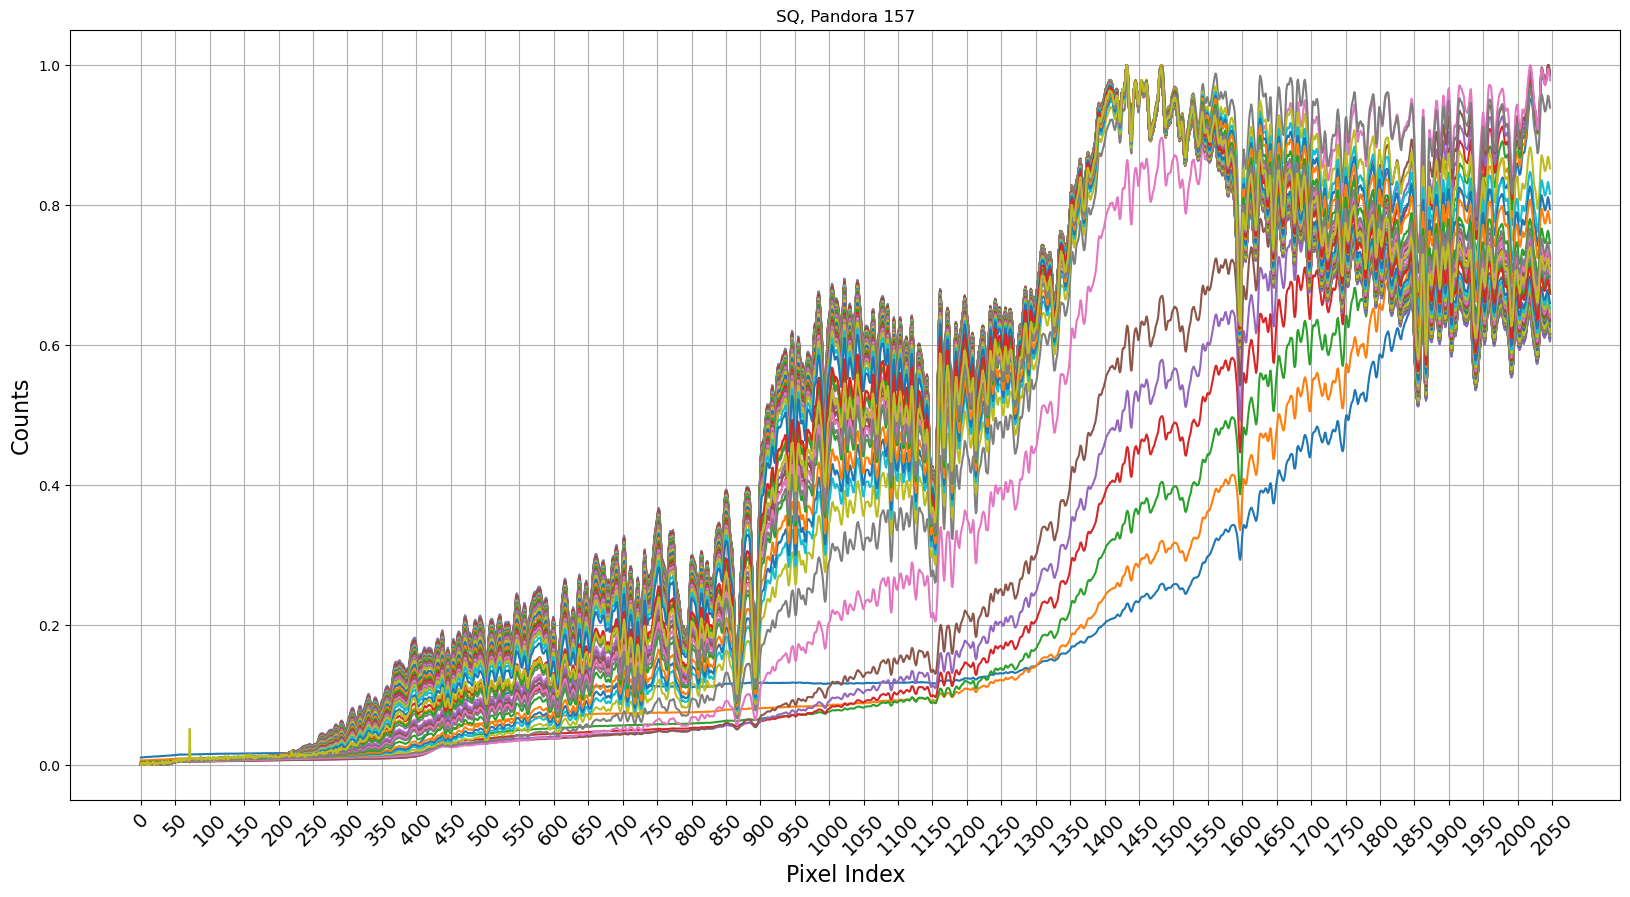

In [23]:
from datetime import datetime, timedelta

# Convert column 2 (Routine Count) to numeric for grouping
data1[2] = pd.to_numeric(data1[2], errors='coerce')

# R = 'SS' # Routine name
# # Define conditions for bright and dark counts
# is_SQ = data1[0] == R
# is_bc = (data1[8] == 1) & (data1[9] == 8) & (data1[10] < 1)
# is_dc = (data1[8] == 1) & (data1[9] == 3) & (data1[10] < 1)

R = 'SQ' # Routine name
# Define conditions for bright and dark counts
is_SQ = data1[0] == R
is_bc = (data1[8] < 3) & (data1[9] == 7) & (data1[10] < 1)
is_dc = (data1[8] < 3) & (data1[9] == 3) & (data1[10] < 1)

# Filter bright and dark rows
SQ_bc_full = data1[is_SQ & is_bc].copy()
SQ_dc_full = data1[is_SQ & is_dc].copy()

# Convert routine count and scale factor
SQ_bc_full['routine'] = SQ_bc_full[2].astype(float)
SQ_dc_full['routine'] = SQ_dc_full[2].astype(float)
SQ_bc_full['scale'] = SQ_bc_full[22].astype(float)
SQ_dc_full['scale'] = SQ_dc_full[22].astype(float)

# Prepare arrays to collect processed spectra
matched_sq = []
routine_ids = []

# Group bright counts by routine number
grouped_bc = SQ_bc_full.groupby('routine')
grouped_dc = SQ_dc_full.set_index('routine')

routine_times = []

for routine, group in grouped_bc:
    if routine in grouped_dc.index:
        # Get corresponding dark count row
        dark_row = grouped_dc.loc[routine]
        
        # If multiple dark rows exist for this routine, use the first one
        if isinstance(dark_row, pd.DataFrame):
            dark_row = dark_row.iloc[0]
        
        # Average bright rows (if more than one)
        bc_scaled = group.iloc[:, 24:2072].astype(float).div(group['scale'], axis=0)
        bc_mean = bc_scaled.mean(axis=0)

        # Scale dark count
        dc_scaled = dark_row.iloc[24:2072].astype(float) / dark_row['scale']

        # Subtract and store
        sq = bc_mean.values - dc_scaled.values
        matched_sq.append(sq)
        routine_ids.append(routine)
        # Extract and adjust time
        time_str = group.iloc[0][1]  # e.g., '20250328T104729.2Z'
        try:
            dt_obj = datetime.strptime(time_str[:15], "%Y%m%dT%H%M%S")  # ignore .2Z part
            dt_adjusted = dt_obj - timedelta(hours=4)
            hhmm = dt_adjusted.strftime("%H%M")
        except Exception as e:
            hhmm = '0000'  # fallback in case of parsing error
        
        routine_times.append(hhmm)

# Convert to array and DataFrame
sq_l0 = np.array(matched_sq)
print(sq_l0.shape)

for i in range(len(sq_l0)):
    sq_l0[i] = sq_l0[i]/ max(sq_l0[i])
sq_l0_df = pd.DataFrame(sq_l0, index=routine_ids)
print(sq_l0.shape)

plt.figure(figsize=(20, 10))
for i in range(len(sq_l0)):
    plt.plot(sq_l0[i])
plt.title(f"{R}, Pandora 157")
plt.xlabel("Pixel Index", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.xticks(np.arange(0, 2051, 50))
plt.xticks(rotation=45, fontsize=14)
# # plt.ylim(0, 1)
# plt.xlim(1425,1450)
plt.grid(True)
plt.show()


(99, 2048)


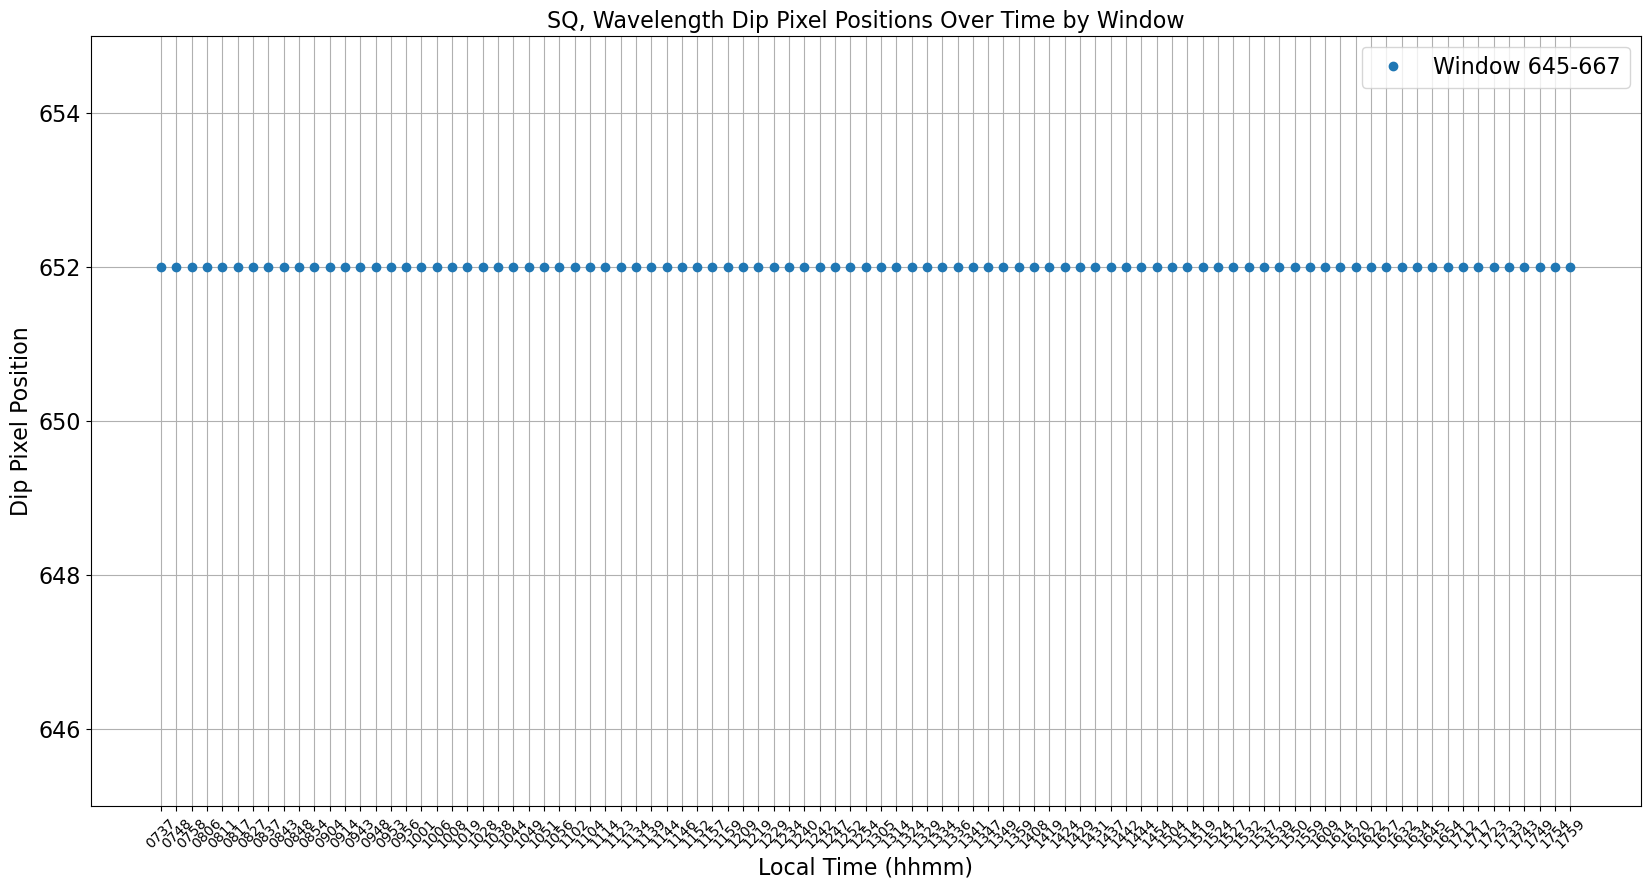

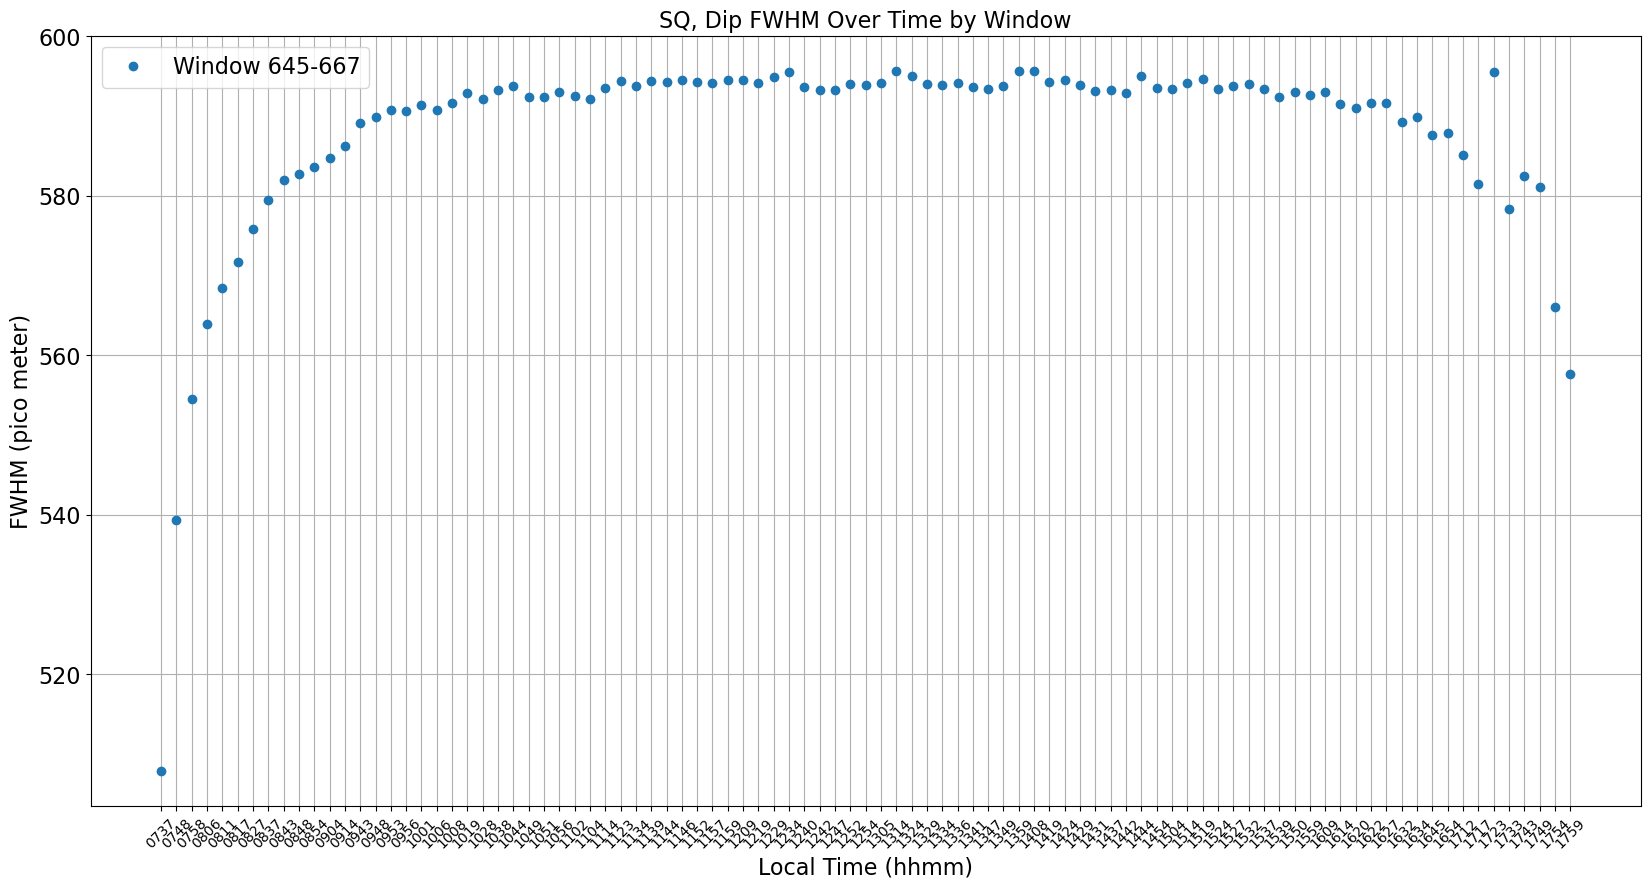

(93,)


In [43]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize all spectra
ss_l0_normalized = np.array([s / np.max(s) for s in sq_l0])
print(ss_l0_normalized.shape)

# Pixel ranges and corresponding prominence thresholds
# window_settings = [
#     {'start': 1360, 'end': 1380, 'prominence': 0.03}
# ]

window_settings = [
    {'start': 645, 'end': 667, 'prominence': 0.0012}
]

# Data storage
dip_tracking = {
    'routine': [],
    'time': [],
    'window': [],
    'dip_pixel': [],
    'fwhm': []
}

# Loop through each spectrum
for i, spectrum in enumerate(ss_l0_normalized):
    inverted = -spectrum  # for dip detection
    for win_idx, win in enumerate(window_settings):
        start, end = win['start'], win['end']
        segment = inverted[start:end]
        
        # Find dips in this window
        peaks, props = find_peaks(segment, prominence=win['prominence'], distance=5)
        widths = peak_widths(segment, peaks, rel_height=0.5)[0]

        # Record dip pixel and FWHM (adjusted to global pixel number)
        for p, w in zip(peaks, widths):
            dip_tracking['routine'].append(i)
            dip_tracking['time'].append(routine_times[i])  # match routine index to time
            dip_tracking['window'].append(f"{start}-{end}")
            dip_tracking['dip_pixel'].append(p + start)
            dip_tracking['fwhm'].append(w)

# Convert to DataFrame
dip_df = pd.DataFrame(dip_tracking)

# Example: visualize one window’s dip pixels over time
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['time'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Local Time (hhmm)',fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
plt.ylim(645,655)
plt.title(f'{R}, Wavelength Dip Pixel Positions Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['time'], subset['fwhm']*120, 'o', label=f'Window {win}')
    
plt.xlabel('Local Time (hhmm)', fontsize=16)
plt.ylabel('FWHM (pico meter)', fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=16)
# plt.ylim(640,660)
plt.title(f'{R}, Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

print((subset['dip_pixel']).shape)

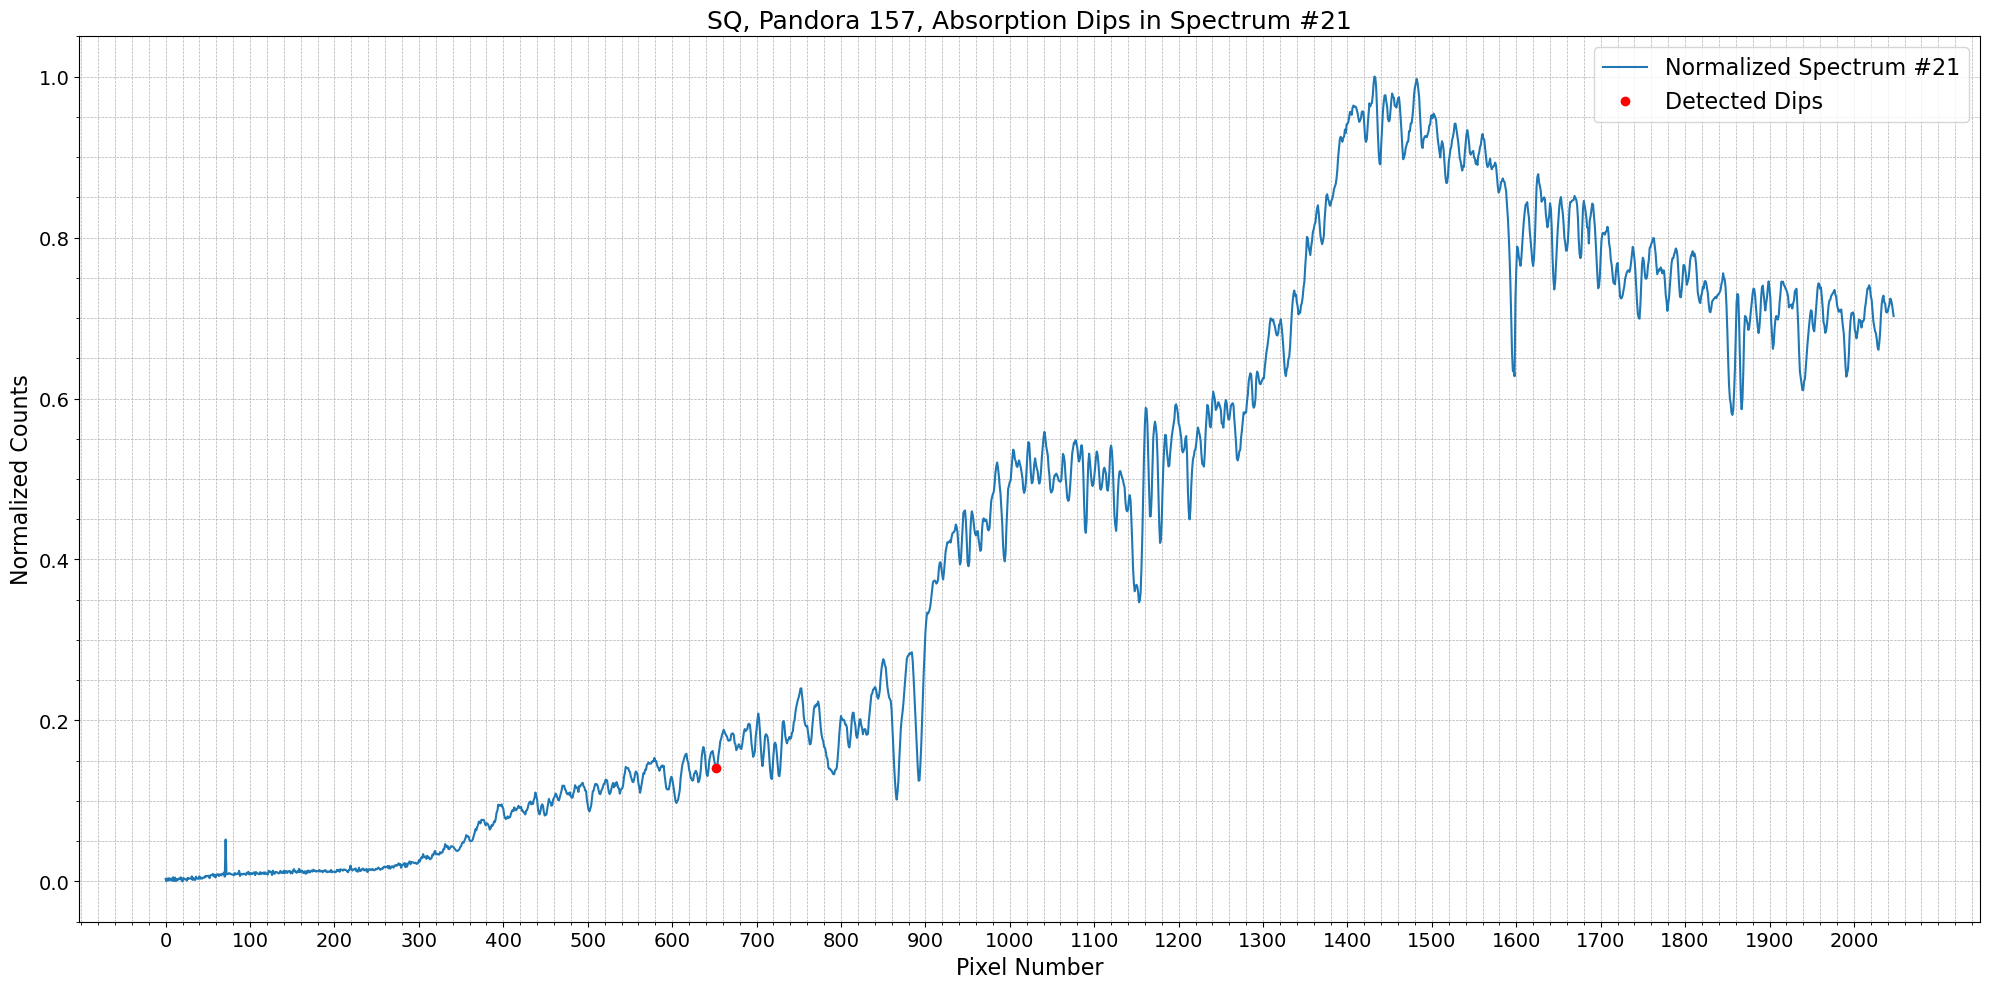

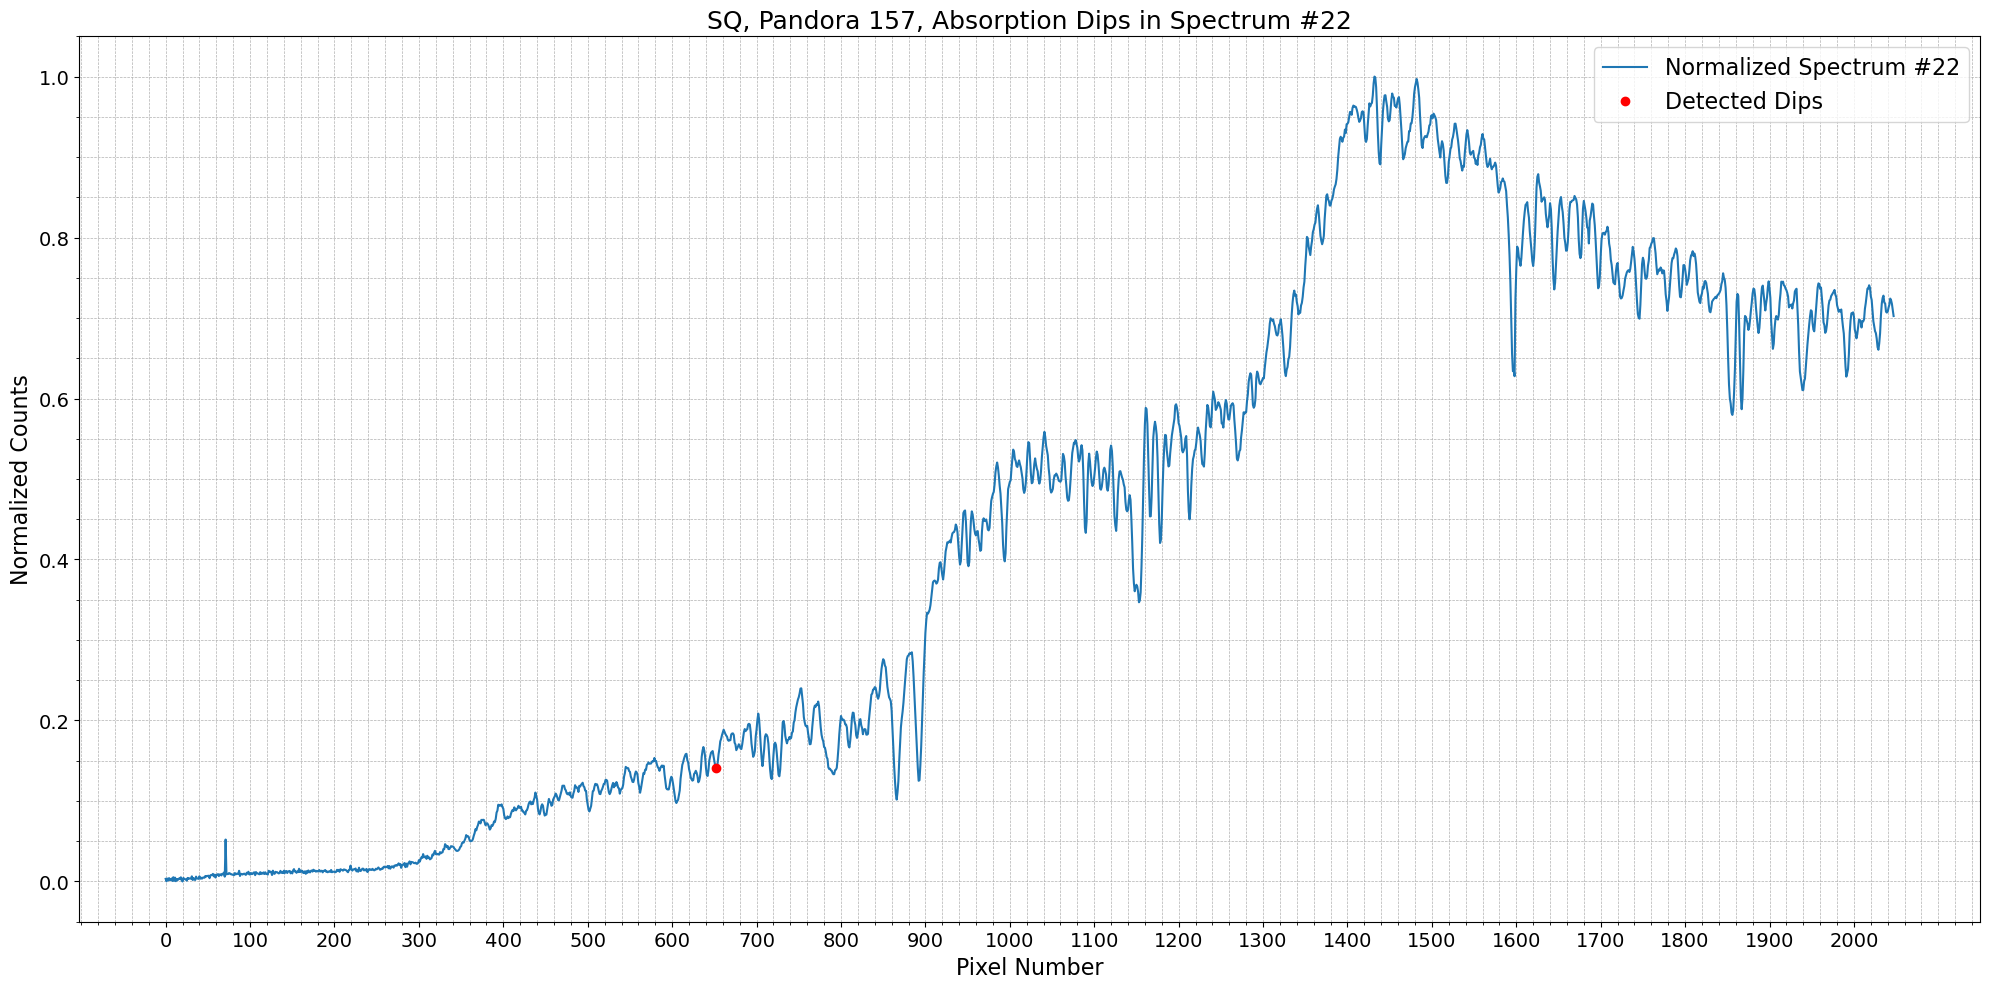

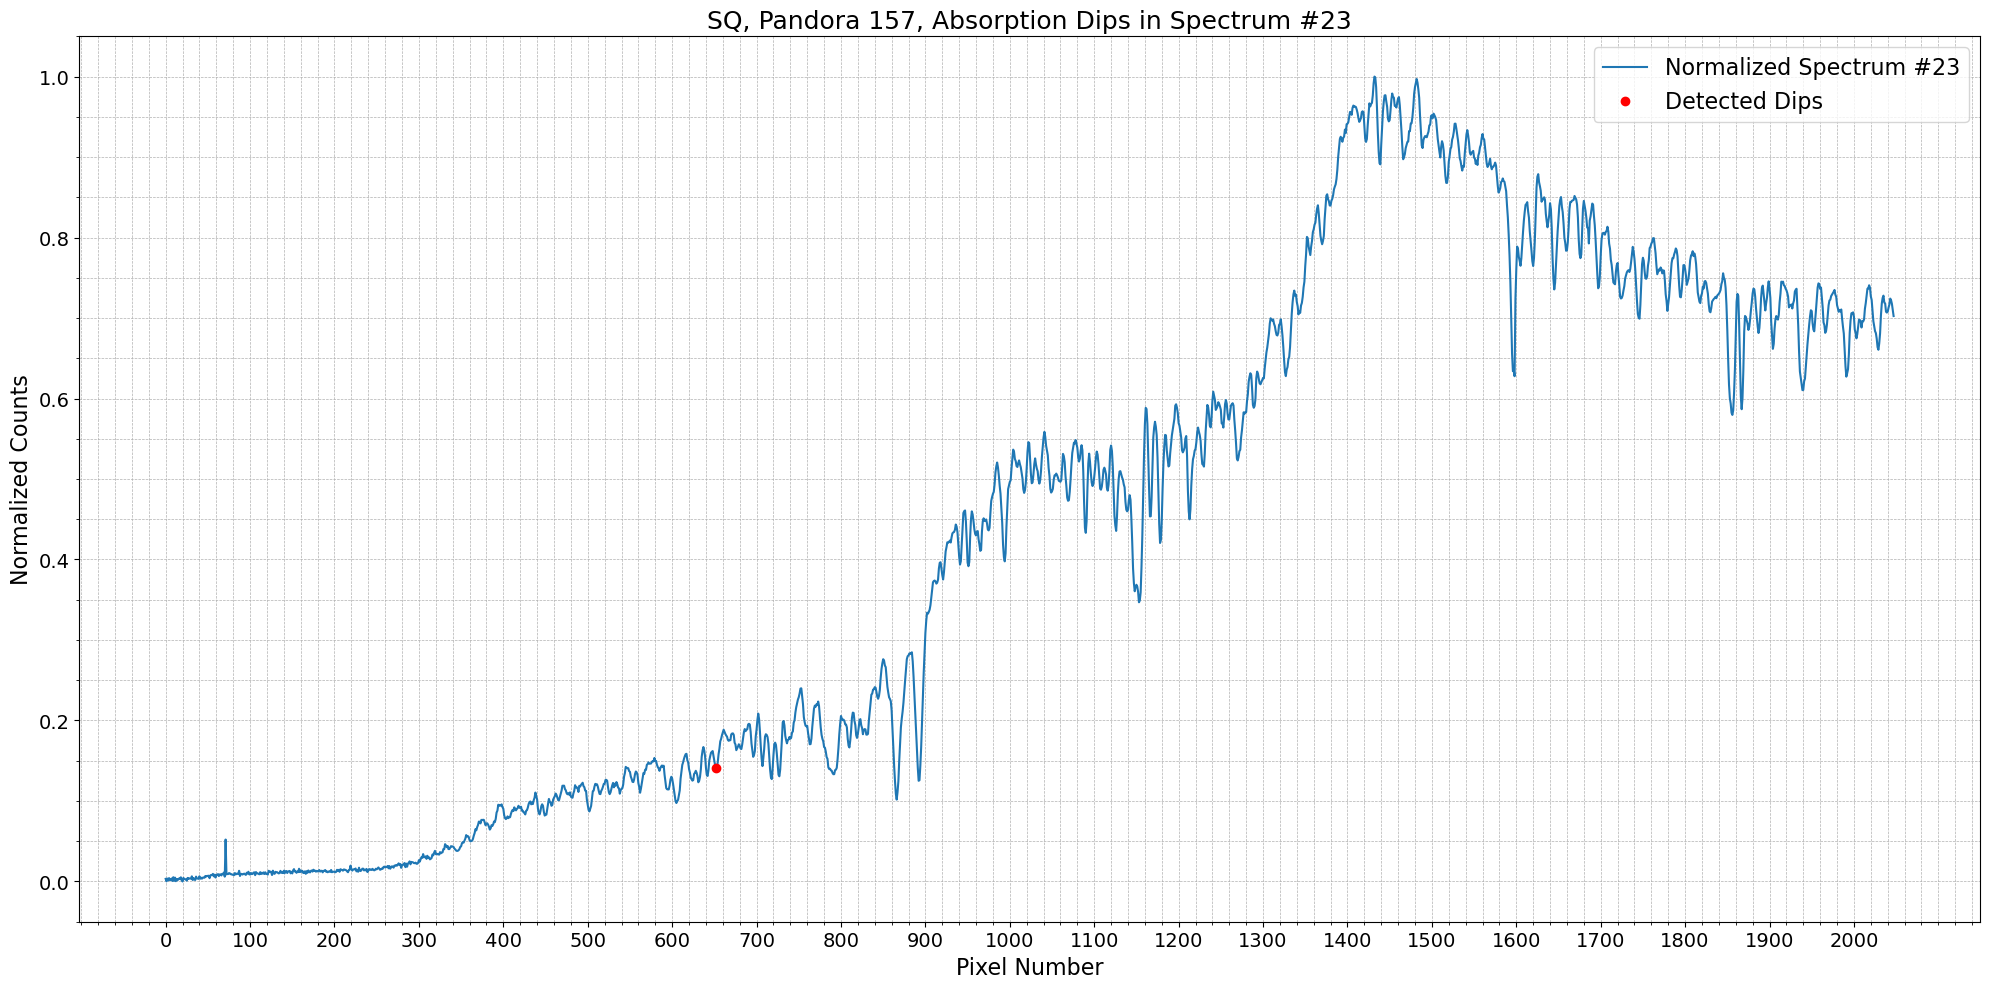

In [35]:
# Plot all normalized spectra with dips marked (one by one)
# for i, spectrum in enumerate(ss_l0_normalized):
for i in range(21, 24):
    # Get dips for this spectrum
    dips_this_spectrum = dip_df[dip_df['routine'] == i]
    dip_pixels = dips_this_spectrum['dip_pixel'].values

    plt.figure(figsize=(20, 10))
    plt.plot(spectrum, label=f'Normalized Spectrum #{i}')
    plt.plot(dip_pixels, spectrum[dip_pixels], 'ro', label='Detected Dips')
    plt.title(f'{R}, Pandora 157, Absorption Dips in Spectrum #{i}', fontsize=18)
    plt.xlabel("Pixel Number", fontsize=16)
    plt.ylabel("Normalized Counts", fontsize=16)
    plt.xticks(np.arange(0, len(spectrum), 100), fontsize=14)
    plt.yticks(fontsize=14)
    plt.minorticks_on()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()

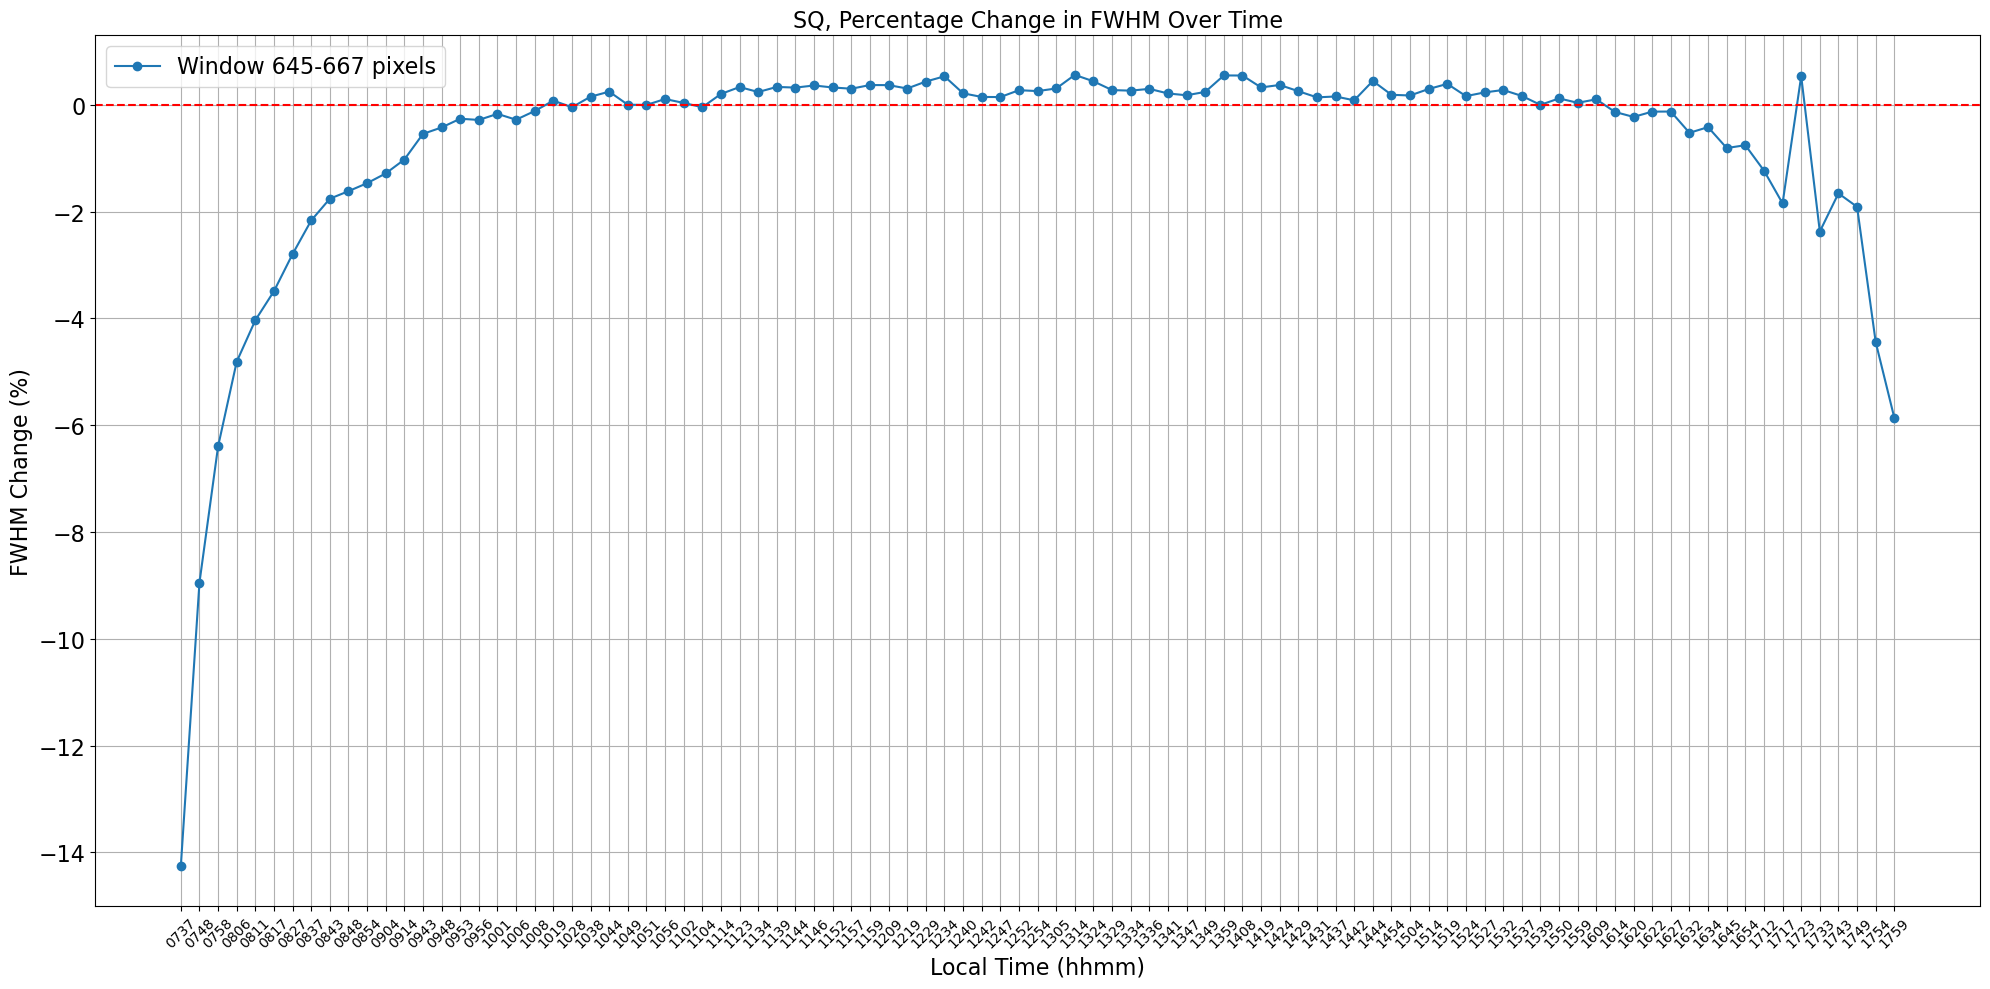

In [37]:
# Convert FWHM from pixels to picometers
dip_df['fwhm_pm'] = dip_df['fwhm'] * 140  # 140 pm per pixel

# Reference FWHMs from routine #12
ref_routine = 30
fwhm_ref = dip_df[dip_df['routine'] == ref_routine][['window', 'fwhm_pm']]

# Create a mapping: window -> reference FWHM
ref_dict = dict(zip(fwhm_ref['window'], fwhm_ref['fwhm_pm']))

# Compute percentage change relative to routine #12
dip_df['fwhm_percent_change'] = dip_df.apply(
    lambda row: ((row['fwhm_pm'] - ref_dict.get(row['window'], np.nan)) / ref_dict.get(row['window'], np.nan)) * 100,
    axis=1
)

# Plot % change over time for each window
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['time'], subset['fwhm_percent_change'], 'o-', label=f'Window {win} pixels')
    
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Local Time (hhmm)', fontsize=16)
plt.ylabel('FWHM Change (%)', fontsize=16)
# plt.xticks(fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=16)
plt.title(f'{R}, Percentage Change in FWHM Over Time', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [458]:
print(subset['dip_pixel'])
print(subset['fwhm'])

0     652
1     652
2     652
3     652
4     652
5     652
6     652
7     652
8     652
9     652
10    652
11    652
12    652
13    652
14    652
15    652
16    652
17    652
18    652
19    652
20    652
21    652
22    652
23    652
24    652
25    652
26    652
27    652
28    652
29    652
30    652
31    652
32    652
33    652
34    652
Name: dip_pixel, dtype: int64
0     4.232664
1     4.494698
2     4.620619
3     4.698928
4     4.737260
5     4.764130
6     4.798425
7     4.829476
8     4.849600
9     4.856559
10    4.863952
11    4.872948
12    4.885786
13    4.947035
14    4.943662
15    4.943560
16    4.949907
17    4.949086
18    4.951495
19    4.958123
20    4.950012
21    4.949486
22    4.951136
23    4.946893
24    4.945215
25    4.948327
26    4.936346
27    4.875624
28    4.845275
29    4.962905
30    4.819266
31    4.854533
32    4.842100
33    4.717045
34    4.647053
Name: fwhm, dtype: float64


(75, 2048)


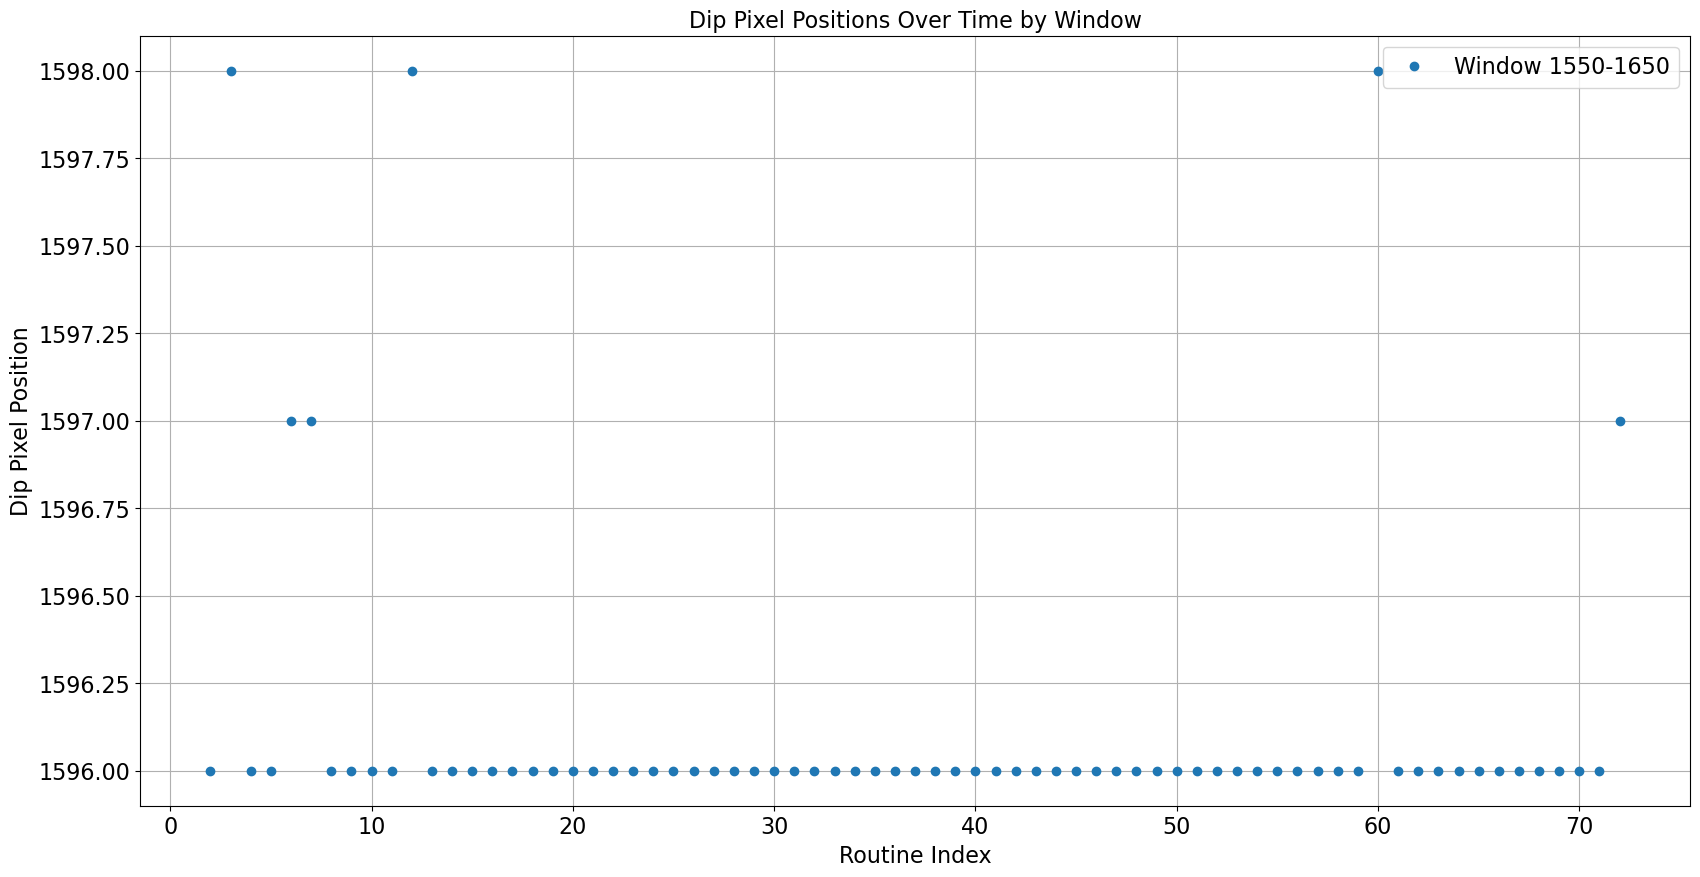

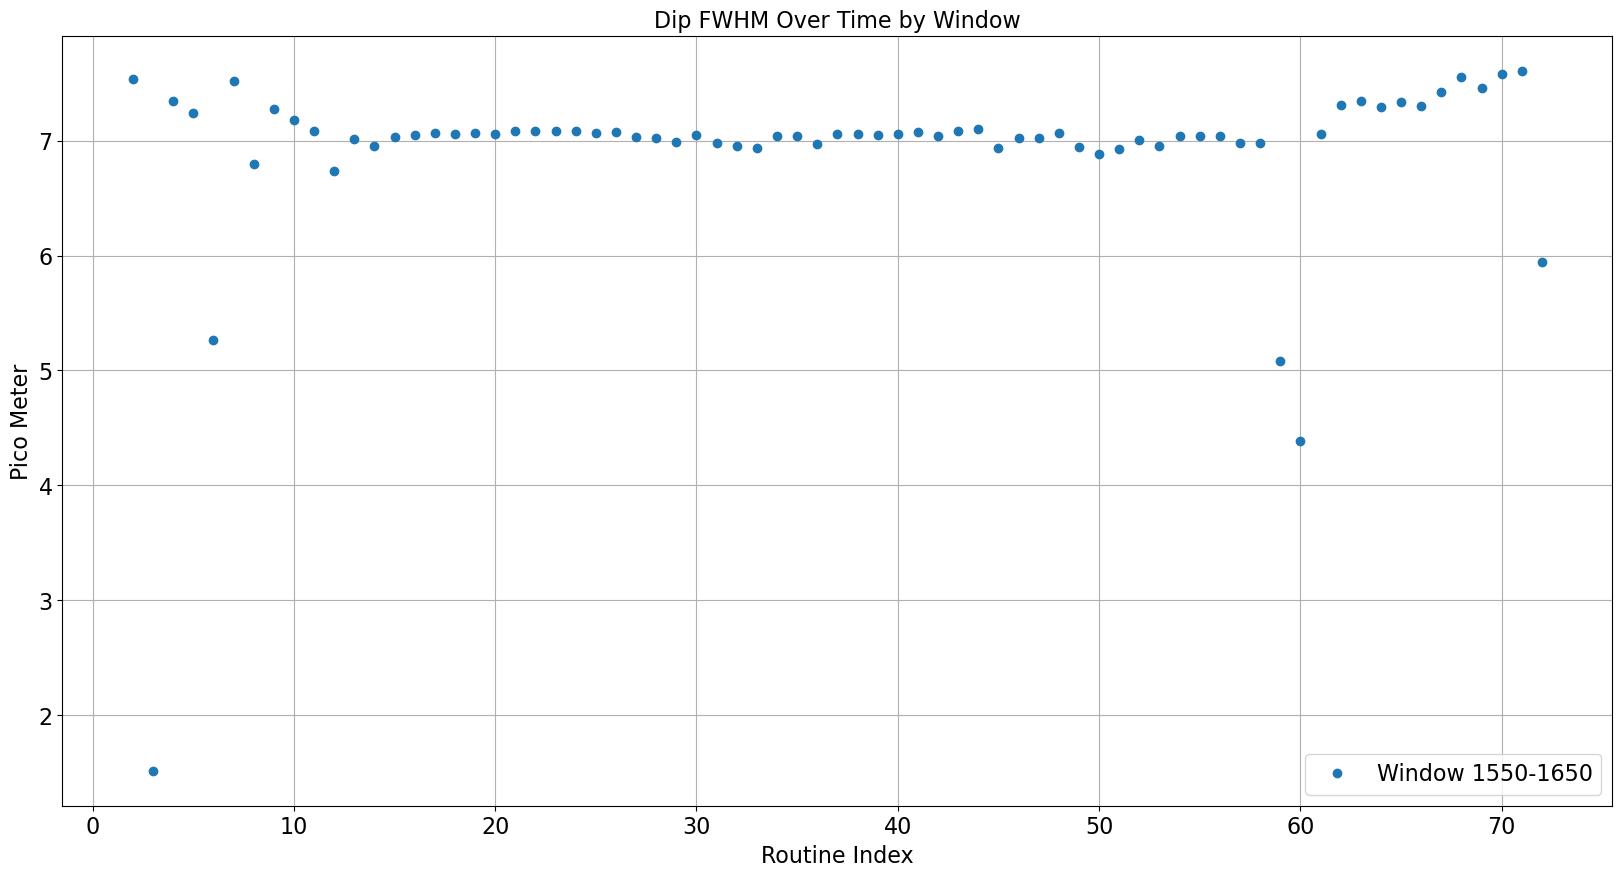

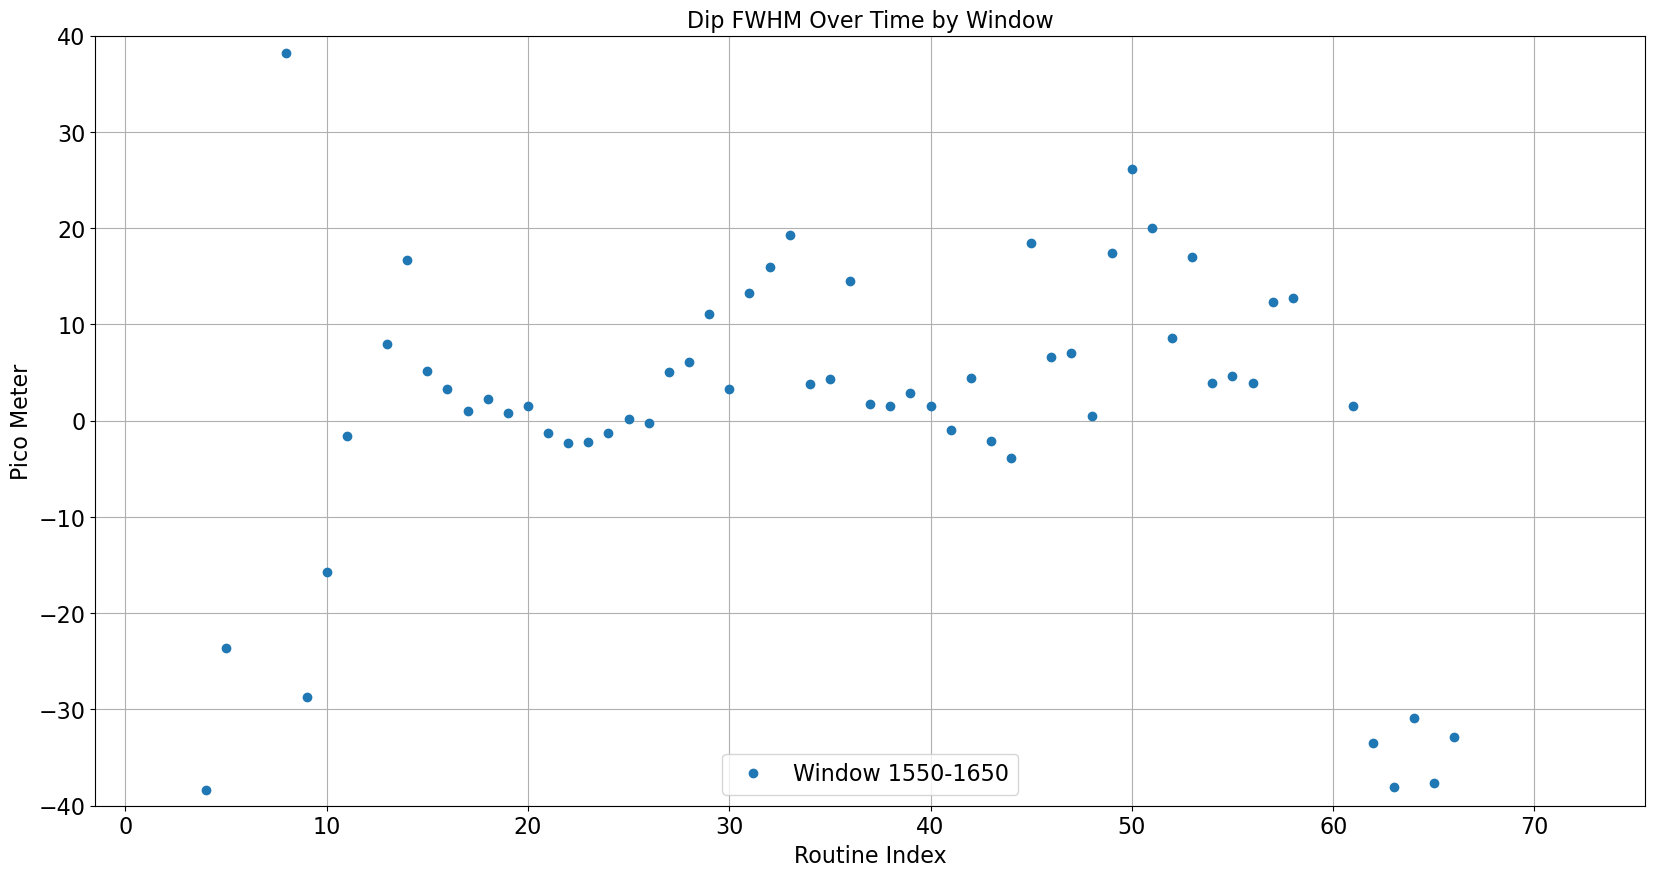

In [351]:
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize all spectra
ss_l0_normalized = np.array([s / np.max(s) for s in sq_l0])
print(ss_l0_normalized.shape)

# Pixel ranges and corresponding prominence thresholds
window_settings = [
    {'start': 1550, 'end': 1650, 'prominence': 0.2}
]

# Data storage
dip_tracking = {
    'routine': [],
    'window': [],
    'dip_pixel': [],
    'fwhm': []
}

# Loop through each spectrum
for i, spectrum in enumerate(ss_l0_normalized):
    inverted = -spectrum  # for dip detection
    for win_idx, win in enumerate(window_settings):
        start, end = win['start'], win['end']
        segment = inverted[start:end]
        
        # Find dips in this window
        peaks, props = find_peaks(segment, prominence=win['prominence'], distance=5)
        widths = peak_widths(segment, peaks, rel_height=0.5)[0]

        # Record dip pixel and FWHM (adjusted to global pixel number)
        for p, w in zip(peaks, widths):
            dip_tracking['routine'].append(i)
            dip_tracking['time'].append(routine_times[i])  # match routine index to time
            dip_tracking['window'].append(f"{start}-{end}")
            dip_tracking['dip_pixel'].append(p + start)
            dip_tracking['fwhm'].append(w)

# Convert to DataFrame
dip_df = pd.DataFrame(dip_tracking)

# Example: visualize one window’s dip pixels over time
plt.figure(figsize=(20, 10))
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['dip_pixel'], 'o', label=f'Window {win}')
plt.xlabel('Routine Index',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dip Pixel Position', fontsize=16)
# plt.ylim(775,900)
plt.title('Dip Pixel Positions Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], subset['fwhm'], 'o', label=f'Window {win}')
    
plt.xlabel('Routine Index', fontsize=16)
plt.ylabel('Pico Meter', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(-40,40)
plt.title('Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

# Plot FWHM variation over time for each window
plt.figure(figsize=(20, 10))
# plt.yscale('log')
for win in dip_df['window'].unique():
    subset = dip_df[dip_df['window'] == win]
    plt.plot(subset['routine'], 990- (subset['fwhm']*140), 'o', label=f'Window {win}')
    
plt.xlabel('Routine Index', fontsize=16)
plt.ylabel('Pico Meter', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-40,40)
plt.title('Dip FWHM Over Time by Window', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

   Wavelength  Intensity
0     62.1440        3.0
1     67.9680        2.0
2     74.4573        0.0
3     74.4810        0.0
4     74.5308        0.0


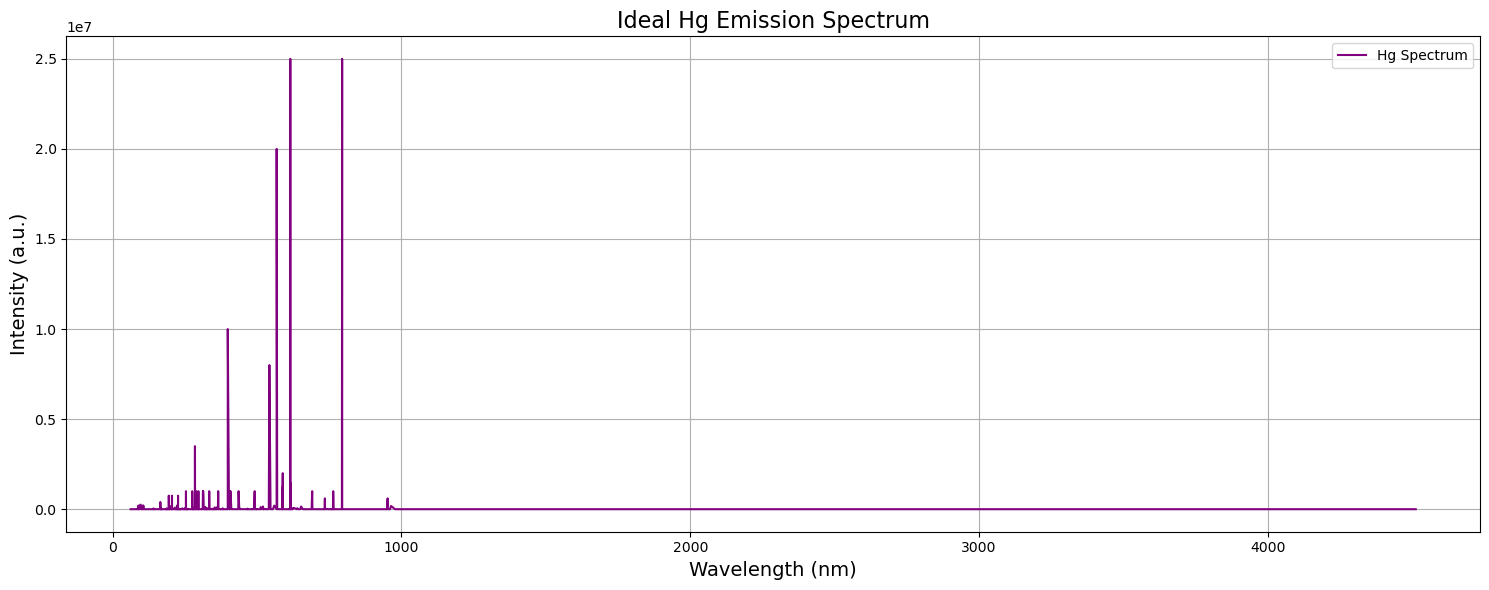

In [362]:
import pandas as pd
import matplotlib.pyplot as plt

# File path
file_path = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Hg lines.csv'

# Load the CSV
df_hg = pd.read_csv(file_path)

# Optional: check if columns need renaming
print(df_hg.head())

# Plot the spectrum
plt.figure(figsize=(15, 6))
plt.plot(df_hg['Wavelength'], df_hg['Intensity'], label='Hg Spectrum', color='purple')
# plt.plot(df_hg.iloc[:, 0], df_hg.iloc[:, 1], label='Hg Spectrum', color='purple')
plt.title('Ideal Hg Emission Spectrum', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [101]:
import numpy as np
np.set_printoptions(threshold = np.inf)
print(calibrated_wavelengths)

[532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809 532.7809
 532.7809 532.7809 532.7809 532.7809 532.7809 532.7

In [61]:
import pandas as pd

# File path
input_file = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1.txt'
output_file = input_file.replace('.txt', '_270_540nm.csv')

# Read skipping comments
df = pd.read_csv(input_file, delim_whitespace=True, comment=';', header=None, names=['Wavelength_nm', 'SSI_Wm2nm'])

# Filter to 270–540 nm range
df_filtered = df[(df['Wavelength_nm'] >= 270) & (df['Wavelength_nm'] <= 541)]

# Save to CSV
df_filtered.to_csv(output_file, index=False)

print(f"Saved filtered spectrum (270–540 nm) to:\n{output_file}")


/var/folders/63/4wnfmmfj2cn8xyjqyr1y8xzw0000gn/T/ipykernel_99149/3713373918.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(input_file, delim_whitespace=True, comment=';', header=None, names=['Wavelength_nm', 'SSI_Wm2nm'])


Saved filtered spectrum (270–540 nm) to:
/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1_270_540nm.csv


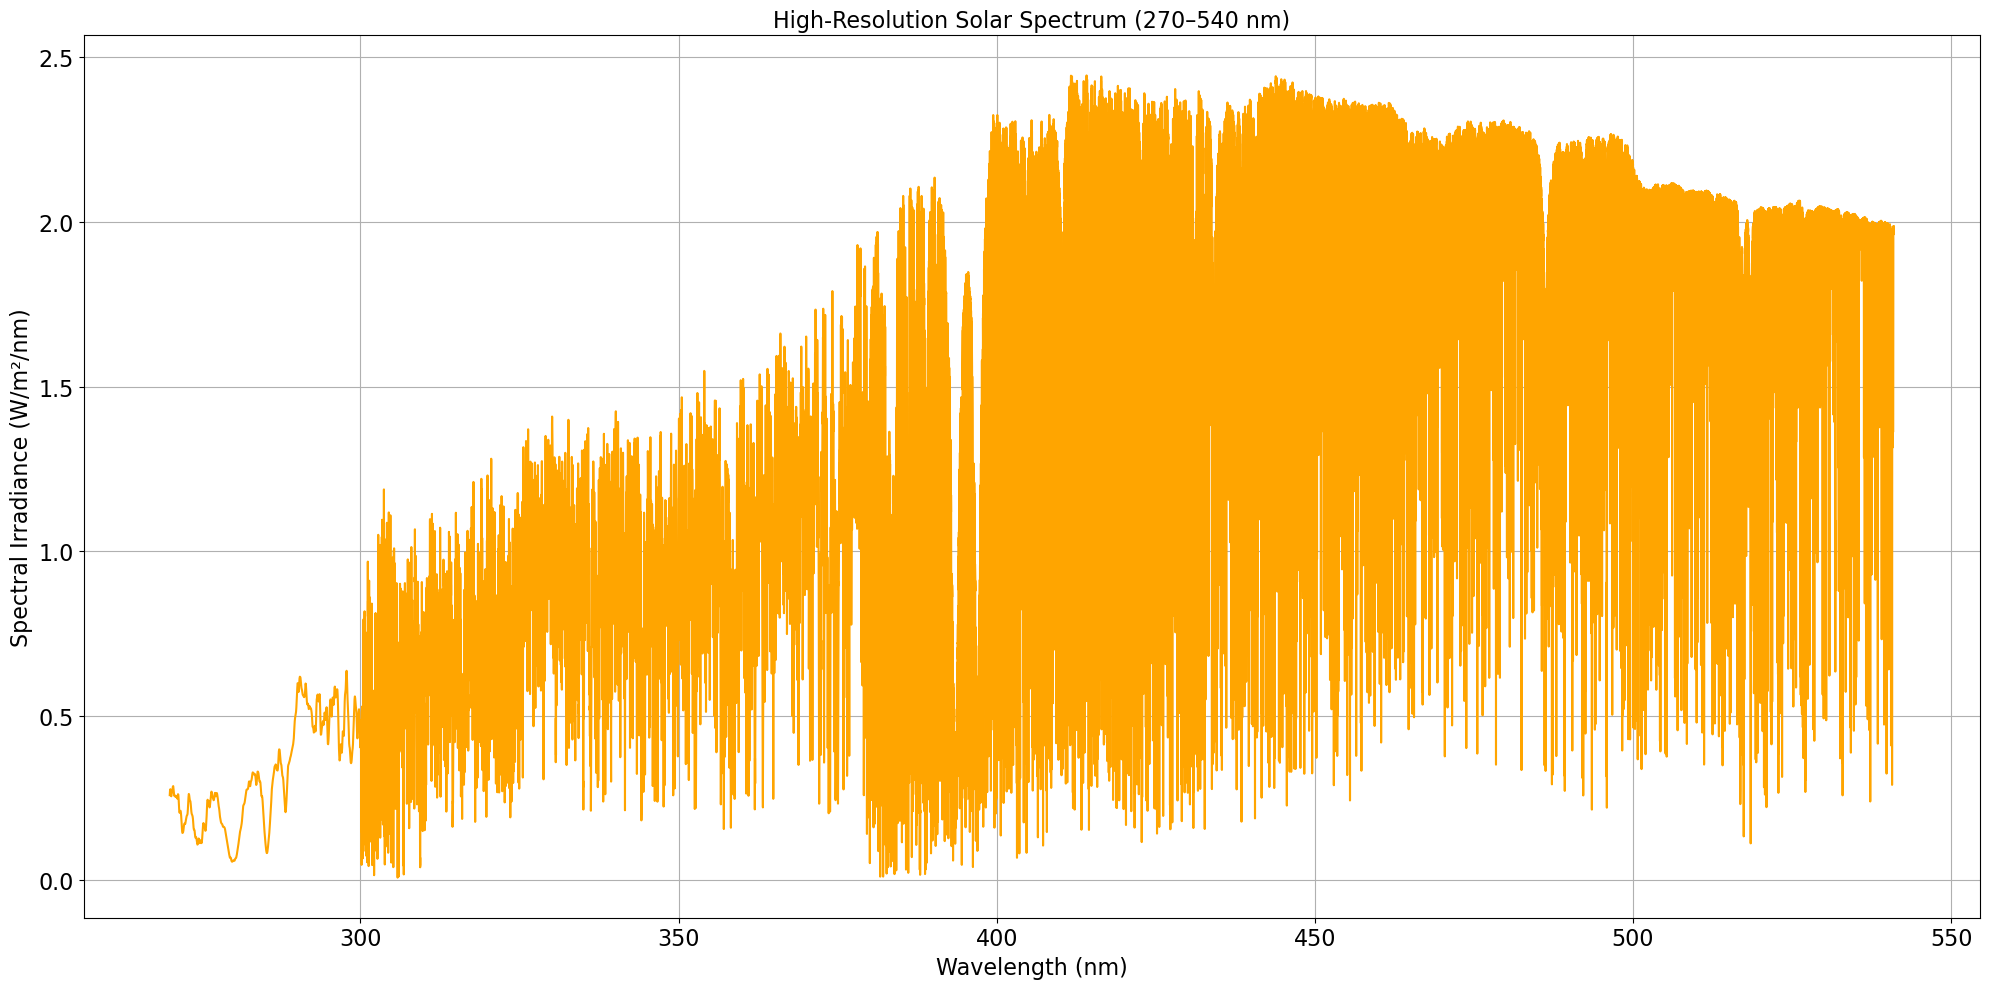

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to filtered CSV file
csv_file = '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1_270_540nm.csv'

# Load CSV
df = pd.read_csv(csv_file)

# Plot
plt.figure(figsize=(20, 10))
plt.plot(df['Wavelength_nm'], df['SSI_Wm2nm'], color='orange')
plt.title('High-Resolution Solar Spectrum (270–540 nm)', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Spectral Irradiance (W/m²/nm)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.xlim(300,400)
plt.grid(True)
plt.tight_layout()
plt.show()


(99, 2048) (99, 2048)


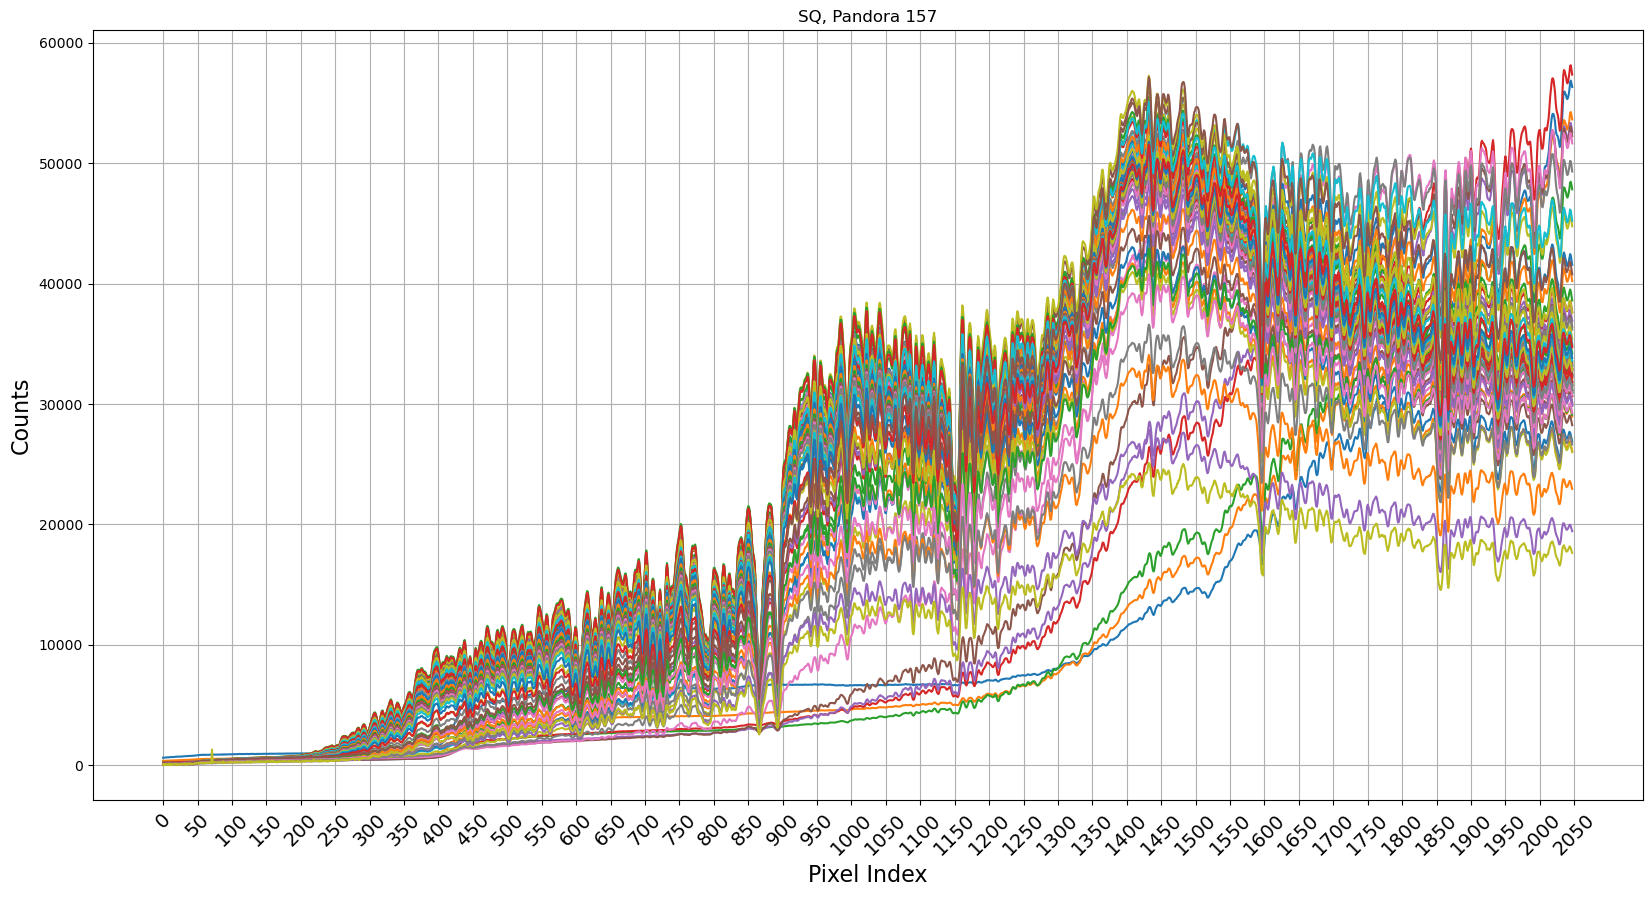

In [13]:
from datetime import datetime, timedelta
import pandas as pd

# Convert column 2 (Routine Count) to numeric for grouping
data1[2] = pd.to_numeric(data1[2], errors='coerce')

R = 'SQ' # Routine name
# Define conditions for bright and dark counts
is_SQ = data1[0] == R
is_bc = (data1[8] < 3) & (data1[9] == 7) & (data1[10] < 1)
is_dc = (data1[8] < 3) & (data1[9] == 3) & (data1[10] < 1)

# R = 'SS' # Routine name
# # Define conditions for bright and dark counts
# is_SQ = data1[0] == R
# is_bc = (data1[8] == 1) & (data1[9] == 8) & (data1[10] < 1)
# is_dc = (data1[8] == 1) & (data1[9] == 3) & (data1[10] < 1)

# Filter bright and dark rows
SQ_bc_full = data1[is_SQ & is_bc].copy()
SQ_dc_full = data1[is_SQ & is_dc].copy()

# Convert routine count and scale factor
SQ_bc_full['routine'] = SQ_bc_full[2].astype(float)
SQ_dc_full['routine'] = SQ_dc_full[2].astype(float)
SQ_bc_full['scale'] = SQ_bc_full[22].astype(float)
SQ_dc_full['scale'] = SQ_dc_full[22].astype(float)

# Prepare arrays to collect processed spectra
matched_sq = []
matched_unc = []  # NEW: to store uncertainty
routine_ids = []
routine_times = []

# Group bright counts by routine number
grouped_bc = SQ_bc_full.groupby('routine')
grouped_dc = SQ_dc_full.set_index('routine')

routine_times = []

for routine, group in grouped_bc:
    if routine in grouped_dc.index:
        # Get corresponding dark count row
        dark_row = grouped_dc.loc[routine]
        
        # If multiple dark rows exist for this routine, use the first one
        if isinstance(dark_row, pd.DataFrame):
            dark_row = dark_row.iloc[0]
        
        # Average bright rows (if more than one)
        bc_scaled = group.iloc[:, 24:2072].astype(float).div(group['scale'], axis=0)
        bc_mean = bc_scaled.mean(axis=0)

        # Scale dark count
        dc_scaled = dark_row.iloc[24:2072].astype(float) / dark_row['scale']

        # Subtract and store
        sq = bc_mean.values - dc_scaled.values
        matched_sq.append(sq)

        # NEW: Subtract and store uncertainty
        bc_uncertainty = group.iloc[:, 2076:4124].astype(float).div(group['scale'], axis=0)
        bc_unc_mean = bc_uncertainty.mean(axis=0)
        dc_uncertainty = dark_row.iloc[2076:4124].astype(float) / dark_row['scale']
        unc = bc_unc_mean.values - dc_uncertainty.values
        matched_unc.append(unc)
        
        routine_ids.append(routine)
        # Extract and adjust time
        time_str = group.iloc[0][1]  # e.g., '20250328T104729.2Z'
        try:
            dt_obj = datetime.strptime(time_str[:15], "%Y%m%dT%H%M%S")  # ignore .2Z part
            dt_adjusted = dt_obj - timedelta(hours=4)
            hhmm = dt_adjusted.strftime("%H%M")
        except Exception as e:
            hhmm = '0000'  # fallback in case of parsing error
        
        routine_times.append(hhmm)


sq_l0 = np.array(matched_sq)
ulnf = np.array(matched_unc)

sq_l0_df = pd.DataFrame(sq_l0, index=routine_ids)
print(sq_l0.shape, ulnf.shape)



# # Convert to array and DataFrame
# sq_l0 = np.array(matched_sq)
# print(sq_l0.shape)

# for i in range(len(sq_l0)):
#     sq_l0[i] = sq_l0[i]/ max(sq_l0[i])
# sq_l0_df = pd.DataFrame(sq_l0, index=routine_ids)
# print(sq_l0.shape)

plt.figure(figsize=(20, 10))
for i in range(len(sq_l0)):
    plt.plot(sq_l0[i])
plt.title(f"{R}, Pandora 157")
plt.xlabel("Pixel Index", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.xticks(np.arange(0, 2051, 50))
plt.xticks(rotation=45, fontsize=14)
# # plt.ylim(0, 1)
# plt.xlim(1425,1450)
plt.grid(True)
plt.show()


In [47]:
wavelengths = []
spectrum = []
scale_factor = None
capture = None

for line in lines:
    line = line.strip()

    # Detect scale factor
    if 'Scale factor of synthetic reference spectrum for OPEN' in line:
        try:
            scale_factor = float(line.split('->')[1].strip())
        except Exception:
            scale_factor = 1.0
        continue

    # Stop condition
    if 'Independent instrumental uncertainty of synthetic reference spectrum for OPEN' in line:
        capture = None
        continue

    # Start capturing wavelength values
    if line.startswith('Wavelengths for synthetic reference spectrum for OPEN'):
        capture = 'wl'
        parts = line.split('->')
        if len(parts) > 1:
            wavelengths.extend(map(float, parts[1].strip().split()))
        continue

    # Start capturing spectrum values
    if line.startswith('Synthetic reference spectrum for OPEN'):
        capture = 'spec'
        parts = line.split('->')
        if len(parts) > 1:
            spectrum.extend(map(float, parts[1].strip().split()))
        continue

    # Keep capturing values line-by-line
    if capture == 'wl':
        try:
            wavelengths.extend(map(float, line.strip().split()))
        except ValueError:
            continue
    elif capture == 'spec':
        try:
            spectrum.extend(map(float, line.strip().split()))
        except ValueError:
            continue

# Convert to NumPy arrays
lostd = np.array(wavelengths)
fstd = np.array(spectrum)

if scale_factor is not None and len(fstd) > 0:
    fstd = fstd * scale_factor

print(f"Parsed lostd: {lostd.shape}, fstd: {fstd.shape}, scale: {scale_factor}")


Parsed lostd: (1973,), fstd: (1973,), scale: 5100000.0


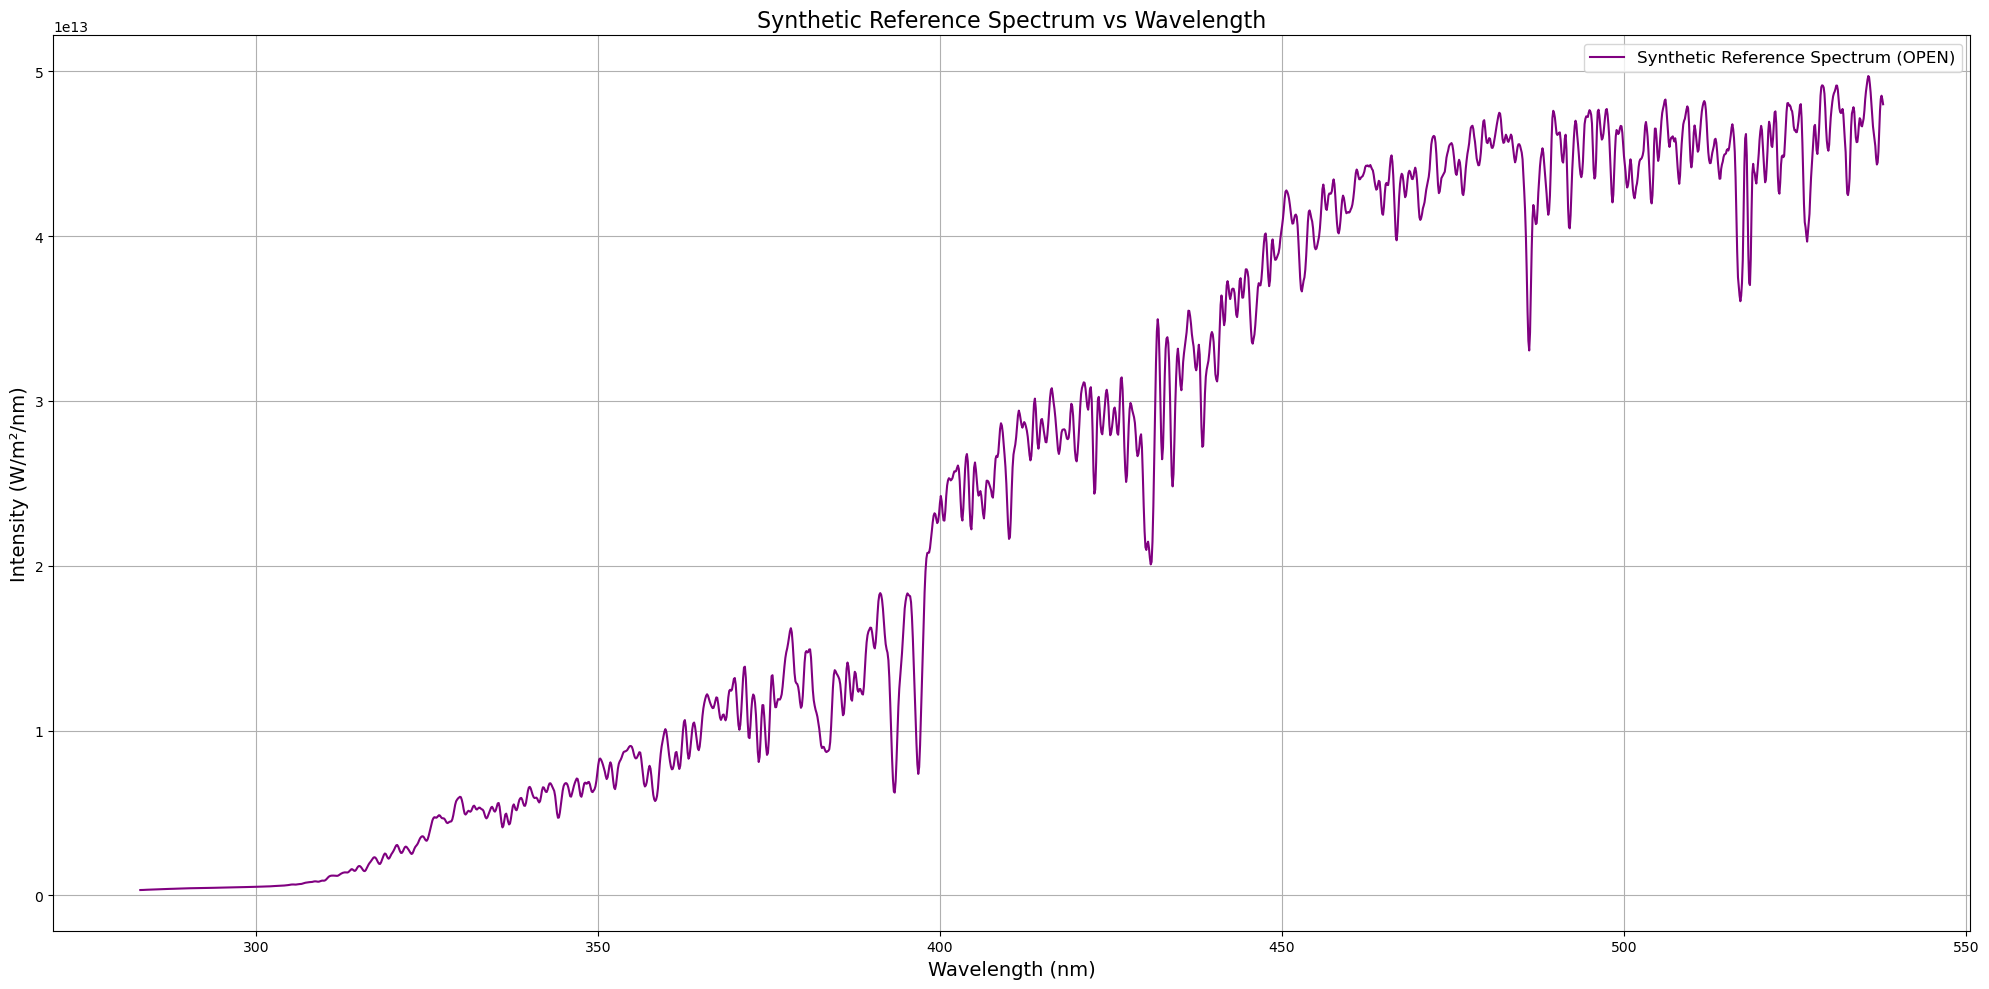

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(lostd, fstd, label='Synthetic Reference Spectrum (OPEN)', color='purple')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Intensity (W/m²/nm)", fontsize=14)
plt.title("Synthetic Reference Spectrum vs Wavelength", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


[0.0009267164, -0.001791262, -0.01054729, 0.01172852, -0.1102532, -2.544954, 77.20954, 414.2817]
350.0
5100000.0
(1973,) (1973,) (1973,) (1973,)


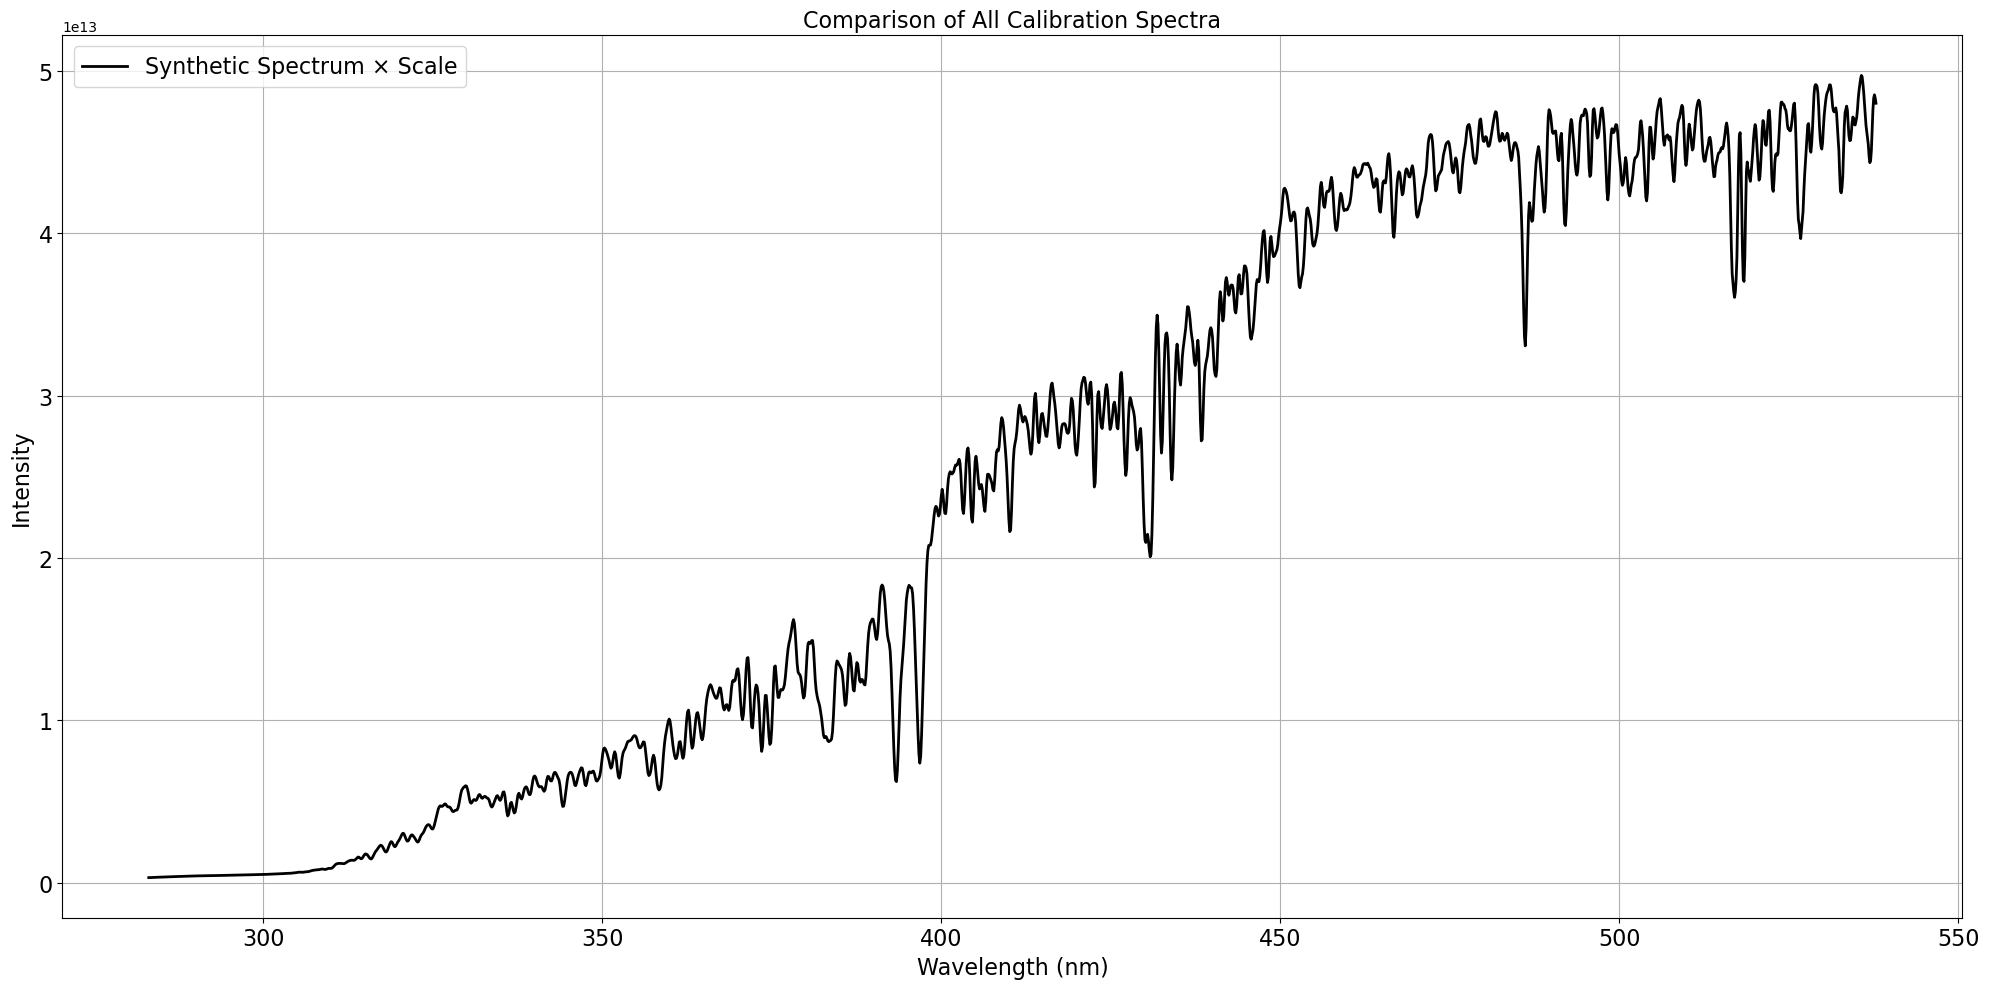

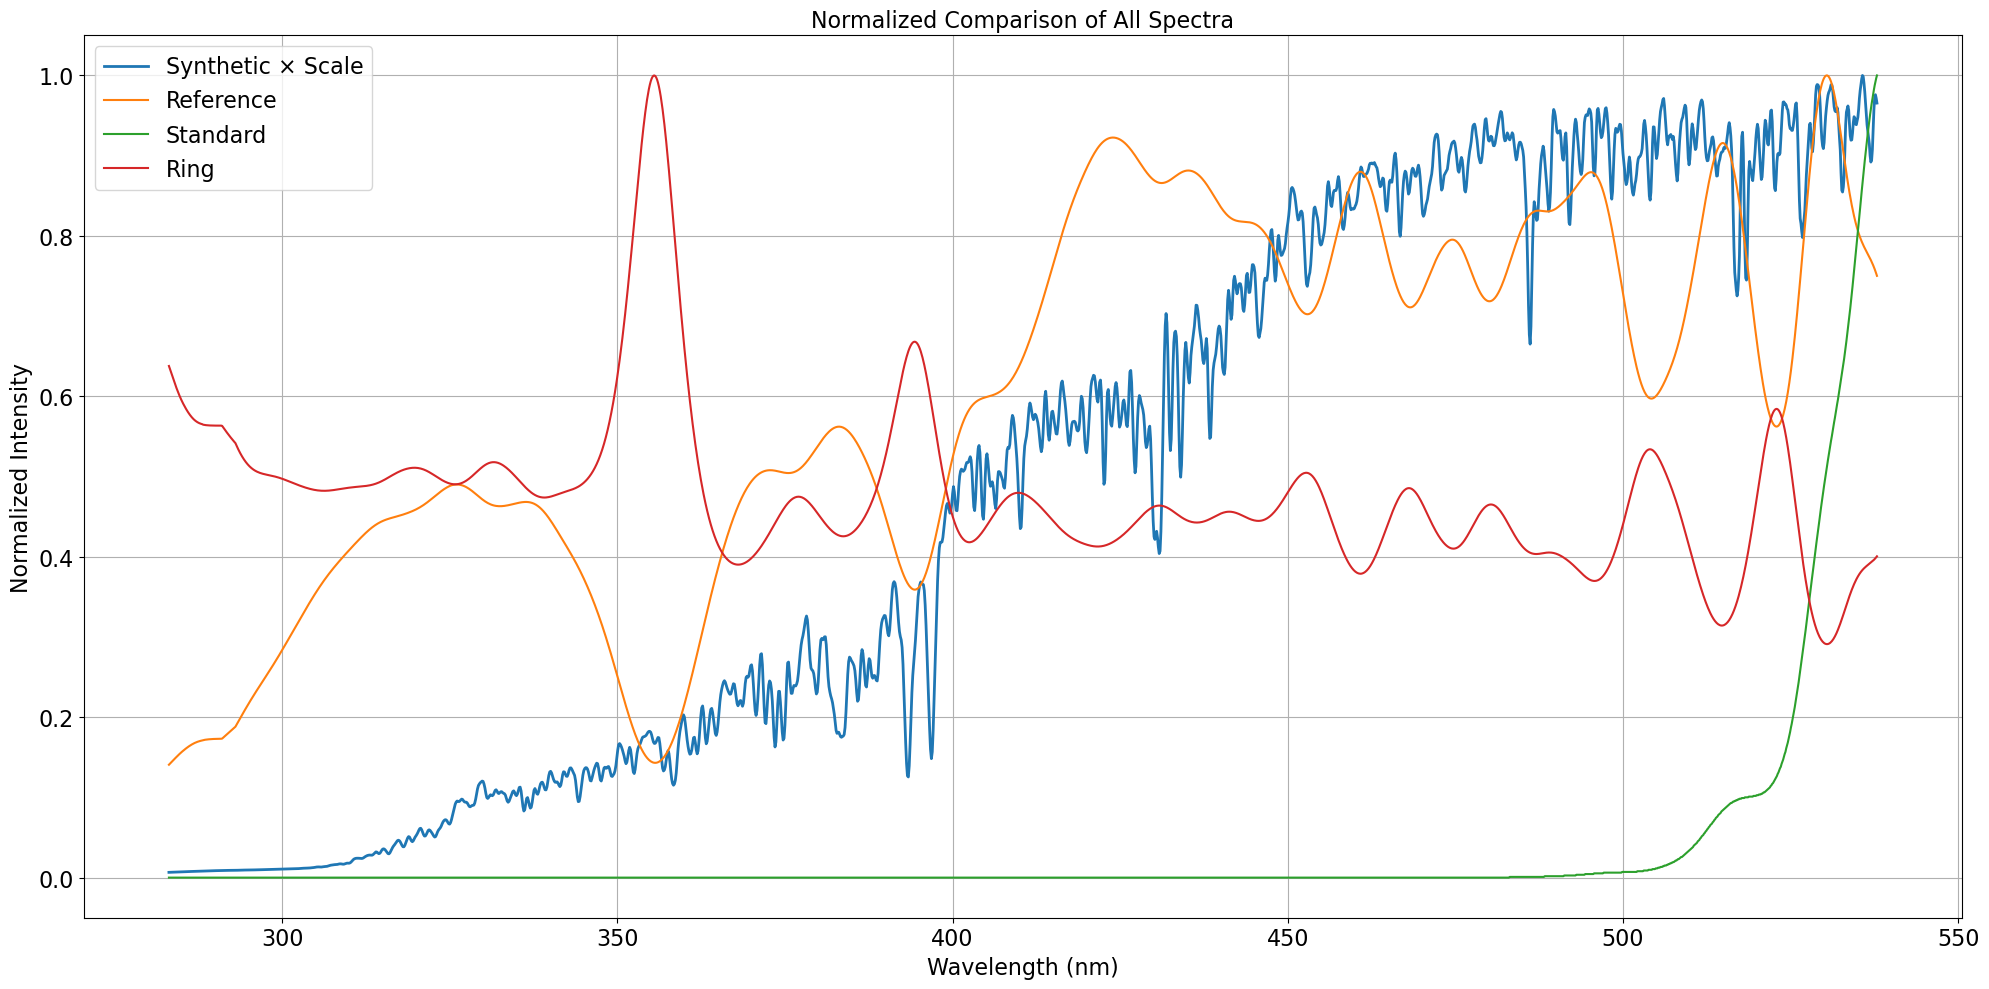

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Load calibration file
with open('/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_CF_session8.txt', 'r') as f:
    lines = f.readlines()

# Initialize
wavelengths = []
synthetic = []
reference = []
standard = []
ring = []
scale_factor = 1.0
capture = None



for line in lines:
    line = line.strip()
    
    # Extract dispersion polynomial
    if 'Dispersion polynomial' in line:
        coeffs = re.findall(r'[-+]?\d*\.\d+e[+-]?\d+', line)
        dispersion_coeffs = list(map(float, coeffs))
        print(dispersion_coeffs)
        continue

    # Extract loref
    if 'Reference wavelength for wavelength change retrieval' in line:
        loref = float(re.findall(r'[-+]?\d*\.\d+', line)[0])
        print(loref)
        continue
    
    # Scale factor
    if line.startswith('Scale factor of synthetic reference spectrum for OPEN'):
        try:
            scale_factor = float(line.split('->')[1].strip())
            print(scale_factor)
        except Exception:
            scale_factor = 1.0
            print(scale_factor)
        continue

    # Handle section starts and possible inline values
    if line.startswith('Wavelengths for synthetic reference spectrum for OPEN'):
        capture = 'wl'
        parts = line.split('->')
        if len(parts) > 1:
            wavelengths.extend(map(float, parts[1].strip().split()))
        continue
    elif line.startswith('Synthetic reference spectrum for OPEN'):
        capture = 'synthetic'
        parts = line.split('->')
        if len(parts) > 1:
            synthetic.extend(map(float, parts[1].strip().split()))
        continue
    elif line.startswith('Reference spectrum for OPEN'):
        capture = 'ref'
        parts = line.split('->')
        if len(parts) > 1:
            reference.extend(map(float, parts[1].strip().split()))
        continue
    elif line.startswith('Standard spectrum for OPEN'):
        capture = 'std'
        parts = line.split('->')
        if len(parts) > 1:
            standard.extend(map(float, parts[1].strip().split()))
        continue
    elif line.startswith('Ring spectrum for OPEN'):
        capture = 'ring'
        parts = line.split('->')
        if len(parts) > 1:
            ring.extend(map(float, parts[1].strip().split()))
        continue
    elif 'Independent instrumental uncertainty' in line:
        capture = None
        continue

    # Append data from multiline blocks
    if capture == 'wl':
        try:
            wavelengths.extend(map(float, line.split()))
        except ValueError:
            continue
    elif capture == 'synthetic':
        try:
            synthetic.extend(map(float, line.split()))
        except ValueError:
            continue
    elif capture == 'ref':
        try:
            reference.extend(map(float, line.split()))
        except ValueError:
            continue
    elif capture == 'std':
        try:
            standard.extend(map(float, line.split()))
        except ValueError:
            continue
    elif capture == 'ring':
        try:
            ring.extend(map(float, line.split()))
        except ValueError:
            continue

# Convert to arrays and trim
lostd = np.array(wavelengths)
f_synthetic = np.array(synthetic) * scale_factor
f_reference = np.array(reference)
f_standard = np.array(standard)
f_ring = np.array(ring)

min_len = min(len(lostd), len(f_synthetic), len(f_reference), len(f_standard), len(f_ring))
lostd = lostd[:min_len]
f_synthetic = f_synthetic[:min_len]
f_reference = f_reference[:min_len]
f_standard = f_standard[:min_len]
f_ring = f_ring[:min_len]

print(f_synthetic.shape, f_reference.shape, f_standard.shape, f_ring.shape)

# Plot
plt.figure(figsize=(20, 10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(lostd, f_synthetic, label='Synthetic Spectrum × Scale', color='black', linewidth=2)
# plt.plot(lostd, f_reference, label='Reference Spectrum', linestyle='--')
# plt.plot(lostd, f_standard, label='Standard Spectrum', linestyle='-.')
# plt.plot(lostd, f_ring, label='Ring Spectrum', linestyle=':')

plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.title("Comparison of All Calibration Spectra", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(lostd, f_synthetic / np.max(f_synthetic), label='Synthetic × Scale', linewidth=2)
plt.plot(lostd, f_reference / np.max(f_reference), label='Reference')
plt.plot(lostd, f_standard / np.max(f_standard), label='Standard')
plt.plot(lostd, f_ring / np.max(f_ring), label='Ring')
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Normalized Intensity", fontsize=16)
plt.title("Normalized Comparison of All Spectra", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define lo from dispersion polynomial
pixels = np.arange(2048)

# Define correct pixel indices starting from 1 (as per manual)
npix = 2048
pix = np.arange(1, npix + 1)

# Convert to scaled pixels using manual equation
pixs = 3.46 * ((pix / npix) - 0.5)

# Evaluate dispersion polynomial on scaled pixels
lo = np.polyval(dispersion_coeffs, pixs)  # corrected wavelengths (air)

# Step 2: Wavelength shift estimation function
def wlchange_chi2(a, lo, lnf, ulnf, loref, lostd, fstd, ys=[], meth=1, npol=2, m=[]):
    nlo = len(lo)
    dlo = np.zeros(nlo)
    for i in range(len(a)):
        dlo += a[i] * (lo - loref)**i
    hlo = lo + dlo
    # Interpolate reference spectrum to adjusted wavelengths
    fstdi = np.interp(hlo, lostd, fstd)
    lnfstdi = np.log(fstdi)
    dlnf = lnfstdi - lnf
    if ys == []:
        losc = (hlo - hlo.min()) / (hlo.max() - hlo.min())
        xr = np.vstack([losc**i for i in range(npol + 1)]).T
        apol, *_ = np.linalg.lstsq(xr, dlnf, rcond=None)
        ys = np.polyval(apol[::-1], losc)
    d = (lnfstdi - lnf - ys) / ulnf
    chi2 = np.sum(d**2) / len(d)
    return chi2


In [9]:
print(lo)

[273.9837713  274.12676898 274.26975663 ... 539.37604902 539.48959571
 539.60312304]


In [95]:
a_shifts = []   # constant shift (a0) over time
a_stretch = []  # optional: linear term (a1)

for i in range(len(sq_l0)):
    # Avoid log(0) and negative values
    safe_sq = np.where(sq_l0[i] <= 0, 1e-10, sq_l0[i])
    lnf = np.log(safe_sq)

    # Avoid division by zero in ulnf
    ulnf_i = np.where(ulnf[i] <= 0, 1e-6, ulnf[i])

    a0 = [0.0, 0.0]  # Initial guess

    try:
        result = minimize(lambda a: wlchange_chi2(a, lo, lnf, ulnf_i, loref, lostd, f_synthetic),
                          a0, method='Nelder-Mead')
        # Define bounds: e.g., shift (a₀) in ±2 nm, stretch (a₁) in ±1%
        # bounds = [(-2.0, 2.0), (-0.01, 0.01)]

        # result = minimize(lambda a: wlchange_chi2(a, lo, lnf, ulnf_i, loref, lostd, f_synthetic),
        #           a0, method='L-BFGS-B', bounds=bounds)

        a_shifts.append(result.x[0])
        a_stretch.append(result.x[1])
    except Exception as e:
        print(f"Optimization failed at index {i}: {e}")
        a_shifts.append(np.nan)
        a_stretch.append(np.nan)


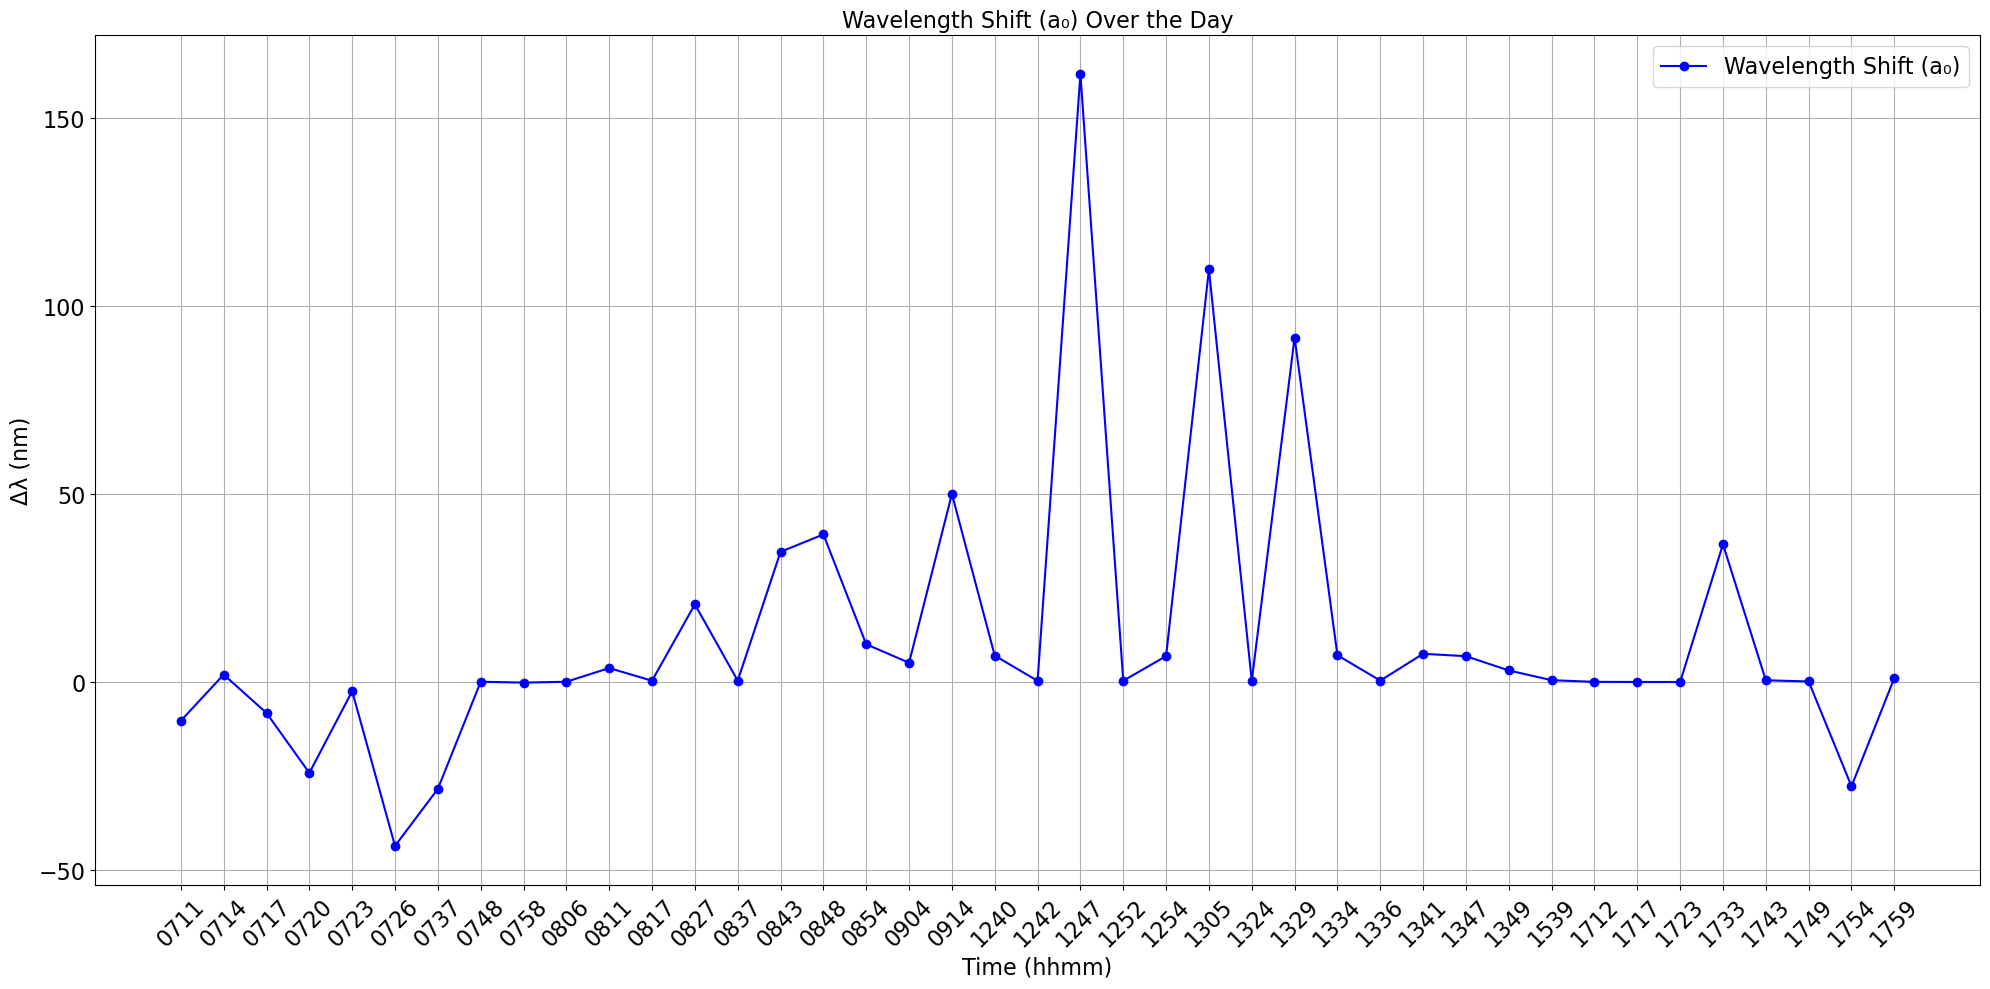

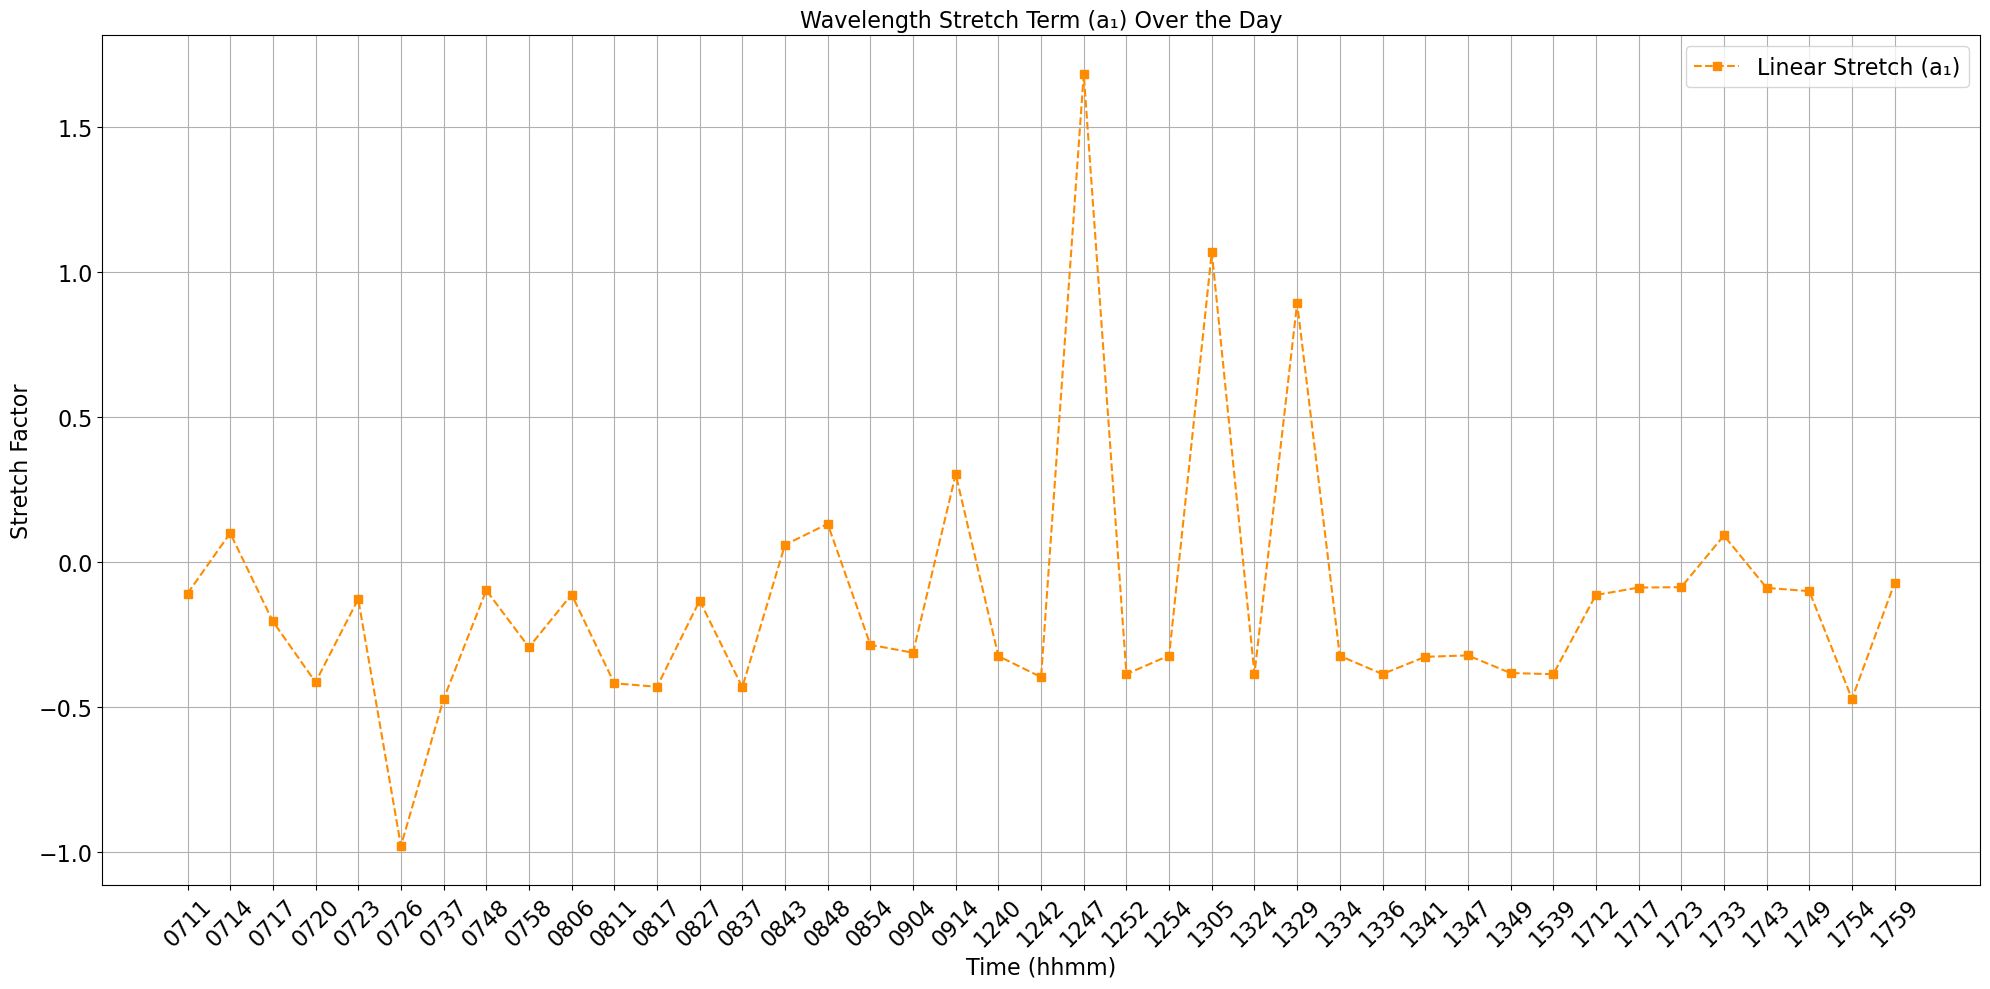

In [97]:
plt.figure(figsize=(20, 10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(routine_times, a_shifts, 'o-', label='Wavelength Shift (a₀)', color='blue')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time (hhmm)', fontsize=16)
plt.ylabel('Δλ (nm)', fontsize=16)
plt.title('Wavelength Shift (a₀) Over the Day', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(20, 10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(routine_times, a_stretch, 's--', label='Linear Stretch (a₁)', color='darkorange')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Time (hhmm)', fontsize=16)
plt.ylabel('Stretch Factor', fontsize=16)
plt.title('Wavelength Stretch Term (a₁) Over the Day', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.show()


Pixel-to-Wavelength Mapping (first 10 values):
Pixel 1: 273.984 nm
Pixel 2: 274.127 nm
Pixel 3: 274.270 nm
Pixel 4: 274.413 nm
Pixel 5: 274.556 nm
Pixel 6: 274.699 nm
Pixel 7: 274.842 nm
Pixel 8: 274.985 nm
Pixel 9: 275.127 nm
Pixel 10: 275.270 nm


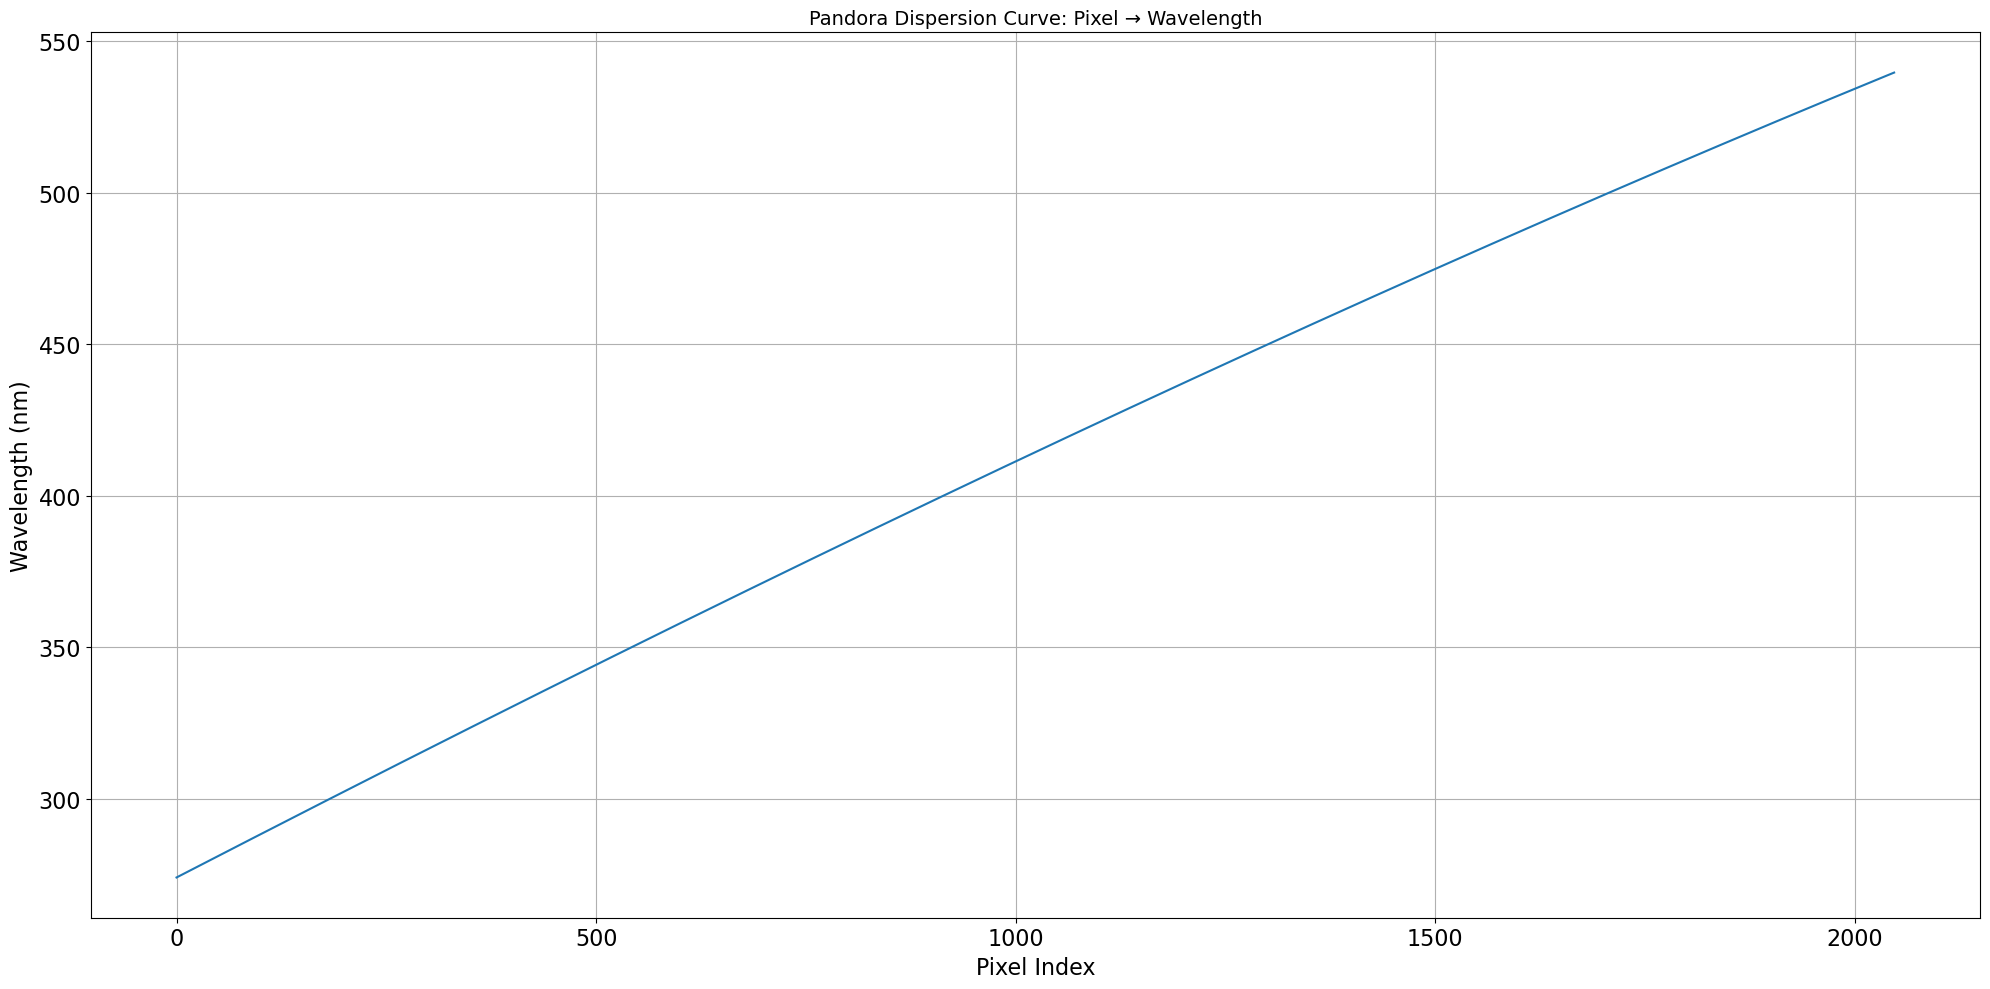

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load dispersion coefficients from the calibration file
dispersion_coeffs = [
    9.267164e-04, -1.791262e-03, -1.054729e-02, 1.172852e-02,
   -1.102532e-01, -2.544954e+00, 7.720954e+01, 4.142817e+02
]  # From highest to lowest degree

# Step 2: Generate scaled pixels according to the manual
npix = 2048  # Number of pixels
pix = np.arange(1, npix + 1)  # Start from 1, not 0
pixs = 3.46 * ((pix / npix) - 0.5)  # Scaled pixels

# Step 3: Evaluate the polynomial
lo = np.polyval(dispersion_coeffs, pixs)  # Final wavelengths

# Step 4: Check output
print("Pixel-to-Wavelength Mapping (first 10 values):")
for i in range(10):
    print(f"Pixel {i+1}: {lo[i]:.3f} nm")

# plot
plt.figure(figsize=(20, 10))
plt.plot(np.arange(npix), lo)
plt.xlabel("Pixel Index", fontsize=16)
plt.ylabel("Wavelength (nm)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Pandora Dispersion Curve: Pixel → Wavelength", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np

np.set_printoptions(threshold = np.inf)

# print(pixs)
print(lo)

[-1.69871021e+04 -1.68691333e+04 -1.67518671e+04 -1.66353001e+04
 -1.65194287e+04 -1.64042495e+04 -1.62897591e+04 -1.61759540e+04
 -1.60628307e+04 -1.59503860e+04 -1.58386164e+04 -1.57275184e+04
 -1.56170889e+04 -1.55073243e+04 -1.53982214e+04 -1.52897768e+04
 -1.51819872e+04 -1.50748494e+04 -1.49683599e+04 -1.48625157e+04
 -1.47573133e+04 -1.46527496e+04 -1.45488214e+04 -1.44455253e+04
 -1.43428583e+04 -1.42408170e+04 -1.41393984e+04 -1.40385992e+04
 -1.39384163e+04 -1.38388466e+04 -1.37398869e+04 -1.36415341e+04
 -1.35437851e+04 -1.34466369e+04 -1.33500863e+04 -1.32541302e+04
 -1.31587657e+04 -1.30639897e+04 -1.29697991e+04 -1.28761910e+04
 -1.27831622e+04 -1.26907100e+04 -1.25988312e+04 -1.25075229e+04
 -1.24167821e+04 -1.23266060e+04 -1.22369915e+04 -1.21479358e+04
 -1.20594359e+04 -1.19714890e+04 -1.18840921e+04 -1.17972425e+04
 -1.17109372e+04 -1.16251735e+04 -1.15399484e+04 -1.14552592e+04
 -1.13711030e+04 -1.12874770e+04 -1.12043785e+04 -1.11218047e+04
 -1.10397529e+04 -1.09582

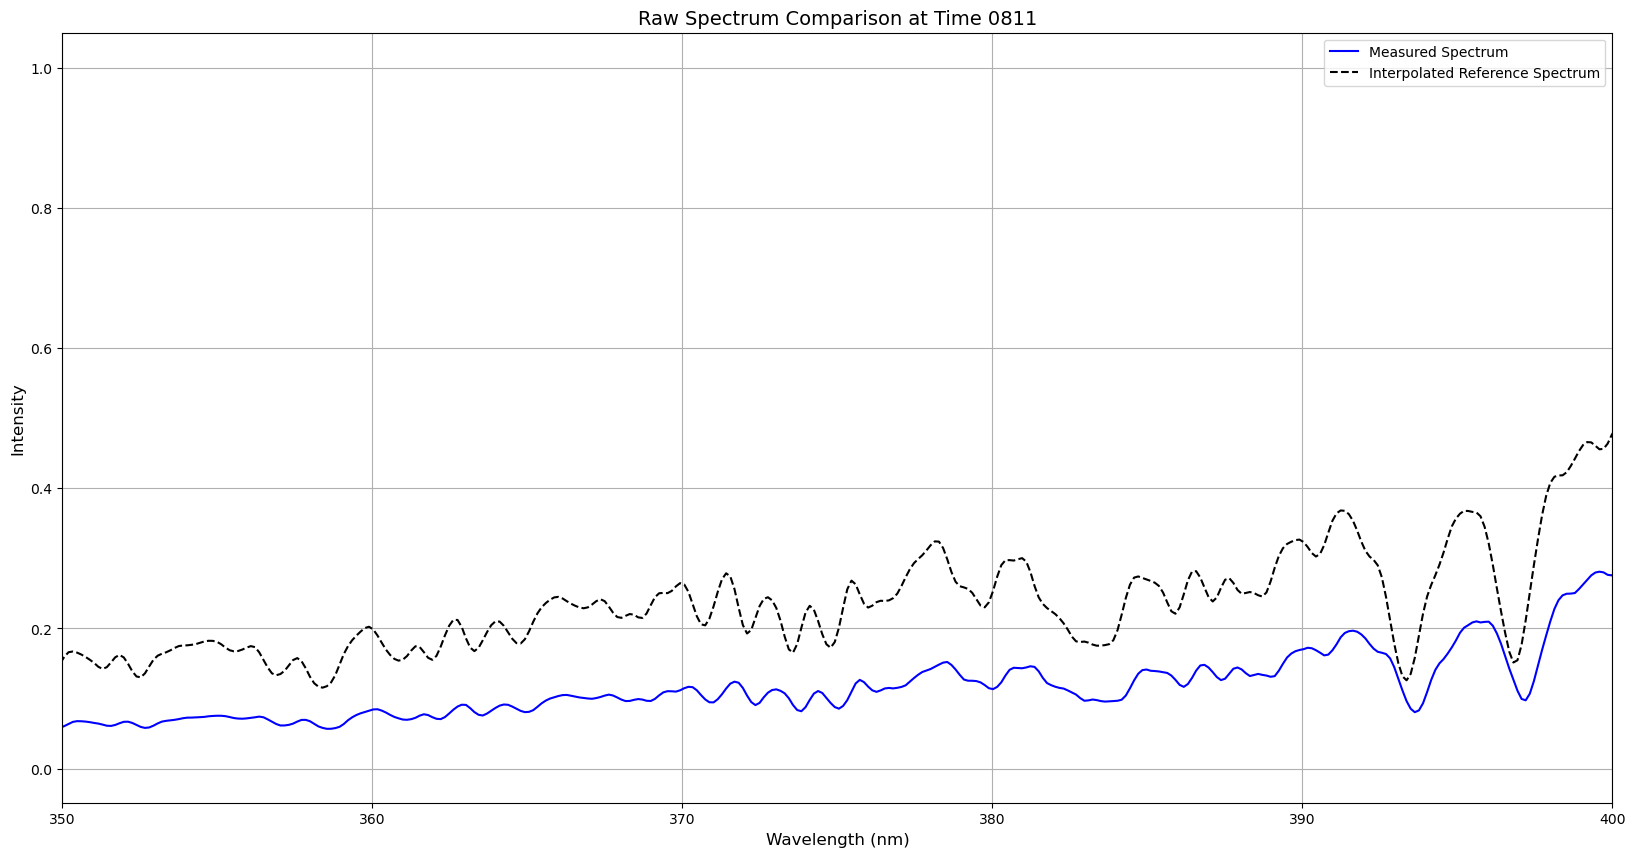

In [45]:
# # Pick a measurement index to visualize
# i = 0  # You can change this to another time point

# # Get wavelength grid and measured spectrum
# hlo = lo  # No shift applied yet (for now)
# safe_meas = np.where(sq_l0[i] <= 0, 1e-10, sq_l0[i])
# lnf = np.log(safe_meas)

# # Interpolate reference spectrum onto the measured spectrum wavelength grid
# fstdi = np.interp(hlo, lostd, f_synthetic)
# lnfstdi = np.log(fstdi)

# # Plot comparison
# plt.figure(figsize=(14, 6))
# plt.plot(hlo, lnf, label='Measured log(Spectrum)', color='blue')
# plt.plot(hlo, lnfstdi, label='Interpolated log(Synthetic Reference)', color='orange', linestyle='--')
# plt.xlabel("Wavelength (nm)", fontsize=12)
# plt.ylabel("log(Intensity)", fontsize=12)
# plt.title(f"Log-Spectrum Comparison at Time {routine_times[i]}", fontsize=14)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Pick an index
i = 10

# Measured spectrum
measured = sq_l0[i]
measured = np.where(measured <= 0, 1e-10, measured)

# Interpolated reference spectrum
fstdi = np.interp(lo, lostd, f_synthetic)

# Plot raw values
plt.figure(figsize=(20, 10))
plt.plot(lo, measured/ max(measured), label='Measured Spectrum', color='blue')
plt.plot(lo, fstdi/ max(fstdi), label='Interpolated Reference Spectrum', color='black', linestyle='--')
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Intensity", fontsize=12)
plt.title(f"Raw Spectrum Comparison at Time {routine_times[i]}", fontsize=14)
plt.legend()
plt.grid(True)
# plt.tight_layout()
plt.xlim(350, 400)
plt.show()



In [53]:
print(fstdi)

[3.26415300e+11 3.26415300e+11 3.26415300e+11 ... 4.79947791e+13
 4.79947791e+13 4.79947791e+13]


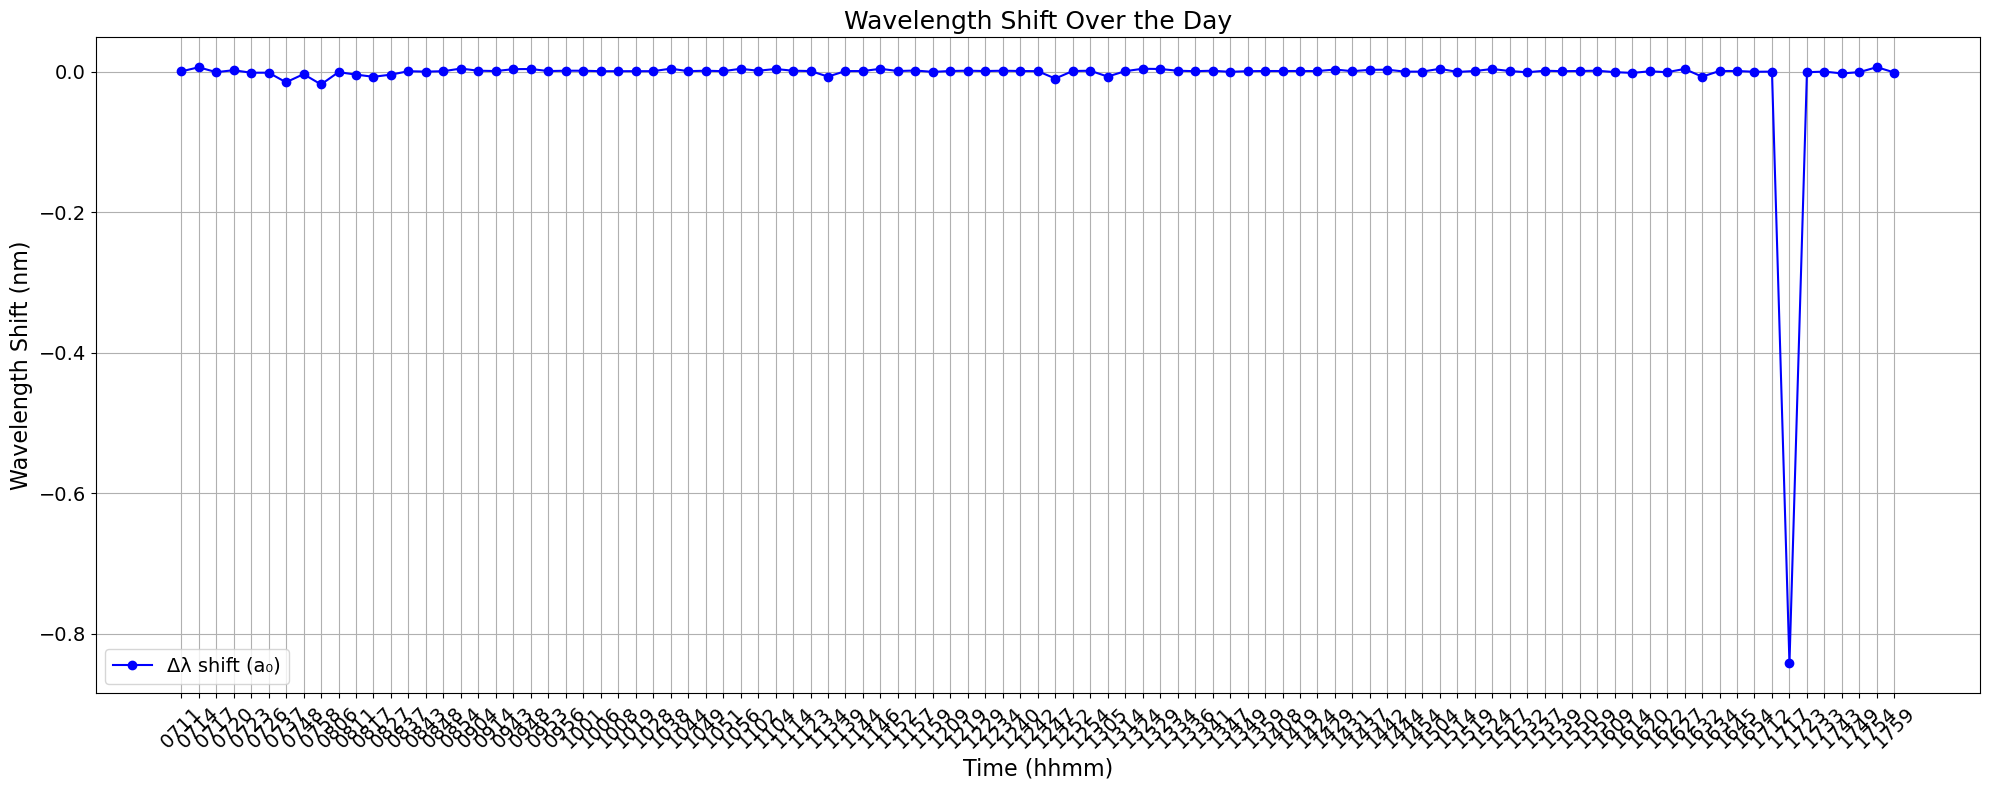

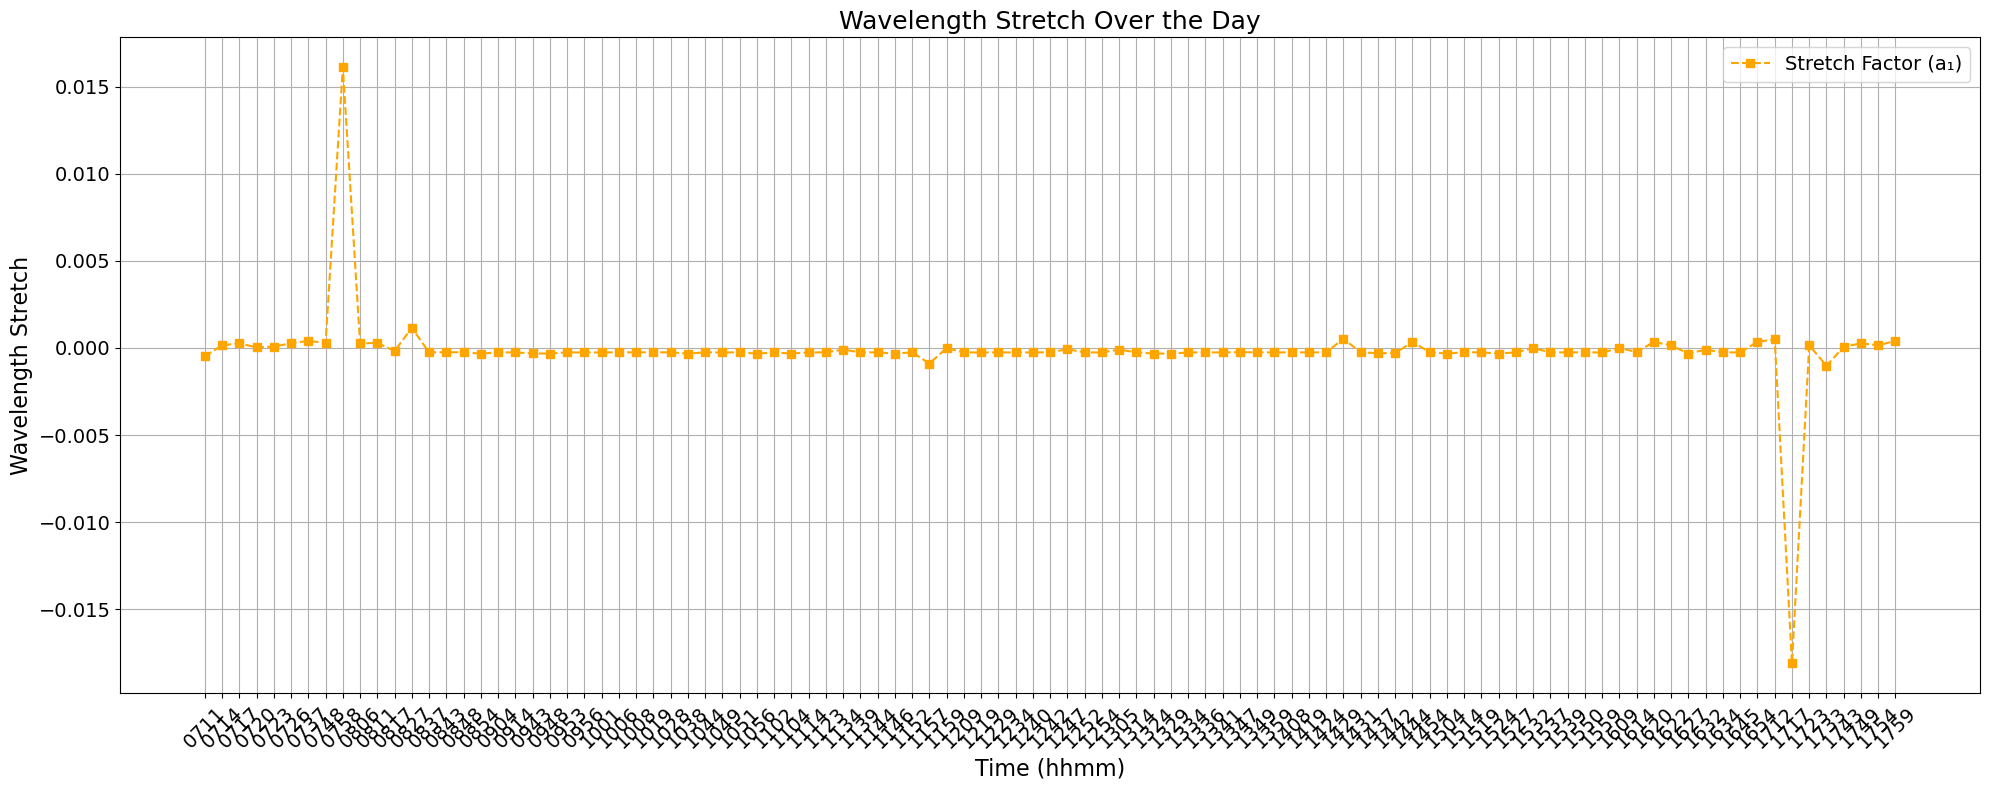

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re

# === Step 1: Load your measured SQ spectrum and uncertainty ===
# Replace `data1` with your full DataFrame if not already in memory
# Make sure to run the earlier extraction code that sets up: `sq_l0`, `ulnf`, `routine_times`

# === Step 2: Load high-res solar spectrum ===
solar_df = pd.read_csv(
    '/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1_270_540nm.csv'
)
solar_wavelengths = solar_df["Wavelength_nm"].values
solar_irradiance = solar_df["SSI_Wm2nm"].values

# === Step 3: Load calibration file for dispersion and loref ===
with open('/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Pandora157s1_CF_session8.txt', 'r') as f:
    lines = f.readlines()

dispersion_coeffs = []
loref = None

for line in lines:
    if "Dispersion polynomial" in line:
        dispersion_coeffs = list(map(float, re.findall(r'[-+]?\d*\.\d+e[+-]?\d+', line)))
    if "Reference wavelength for wavelength change retrieval" in line:
        loref = float(re.findall(r'[-+]?\d*\.\d+', line)[0])

# === Step 4: Compute pixel-wise wavelengths from dispersion ===
npix = 2048
pix = np.arange(1, npix + 1)
pixs = 3.46 * ((pix / npix) - 0.5)
# lo = np.polyval(dispersion_coeffs[::-1], pixs)  # match coeff order
lo = np.polyval(dispersion_coeffs, pixs)

# print(lo)

# === Step 5: Define chi² wavelength shift estimation ===
def wlchange_chi2(a, lo, lnf, ulnf, loref, lostd, fstd, npol=2):
    hlo = lo + sum(a[i] * (lo - loref) ** i for i in range(len(a)))
    fstdi = np.interp(hlo, lostd, fstd)
    lnfstdi = np.log(np.where(fstdi <= 0, 1e-10, fstdi))
    dlnf = lnfstdi - lnf
    losc = (hlo - hlo.min()) / (hlo.max() - hlo.min())
    X = np.vstack([losc ** i for i in range(npol + 1)]).T
    beta, *_ = np.linalg.lstsq(X, dlnf, rcond=None)
    ys = X @ beta
    d = (lnfstdi - lnf - ys) / ulnf
    return np.sum(d**2) / len(d)

# === Step 6: Run wavelength shift estimation over all measurements ===
a_shifts, a_stretch = [], []
for i in range(len(sq_l0)):
    safe_sq = np.where(sq_l0[i] <= 0, 1e-10, sq_l0[i])
    lnf = np.log(safe_sq)
    unc_i = np.where(ulnf[i] <= 0, 1e-6, ulnf[i])

    try:
        bounds = [(-2.0, 2.0), (-0.01, 0.01)]  # nm shift, percent scale
        a0 = [0.0, 0.0]
        # result = minimize(lambda a: wlchange_chi2(a, lo, lnf, unc_i, loref, solar_wavelengths, solar_irradiance),
        #                   a0, method='L-BFGS-B', bounds=bounds)
        result = minimize(lambda a: wlchange_chi2(a, lo, lnf, unc_i, loref, solar_wavelengths, solar_irradiance),
                  a0, method='Nelder-Mead')
        a_shifts.append(result.x[0])
        a_stretch.append(result.x[1])
    except Exception as e:
        print(f"Failed at index {i}: {e}")
        a_shifts.append(np.nan)
        a_stretch.append(np.nan)

# === Step 7: Plot wavelength shift and stretch over the day ===
plt.figure(figsize=(20, 8))
plt.plot(routine_times, a_shifts, 'o-', label='Δλ shift (a₀)', color='blue')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (hhmm)", fontsize=16)
plt.ylabel("Wavelength Shift (nm)", fontsize=16)
plt.title("Wavelength Shift Over the Day", fontsize=18)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(routine_times, a_stretch, 's--', label='Stretch Factor (a₁)', color='orange')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (hhmm)", fontsize=16)
plt.ylabel("Wavelength Stretch", fontsize=16)
plt.title("Wavelength Stretch Over the Day", fontsize=18)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


Routine index for 1717: 92


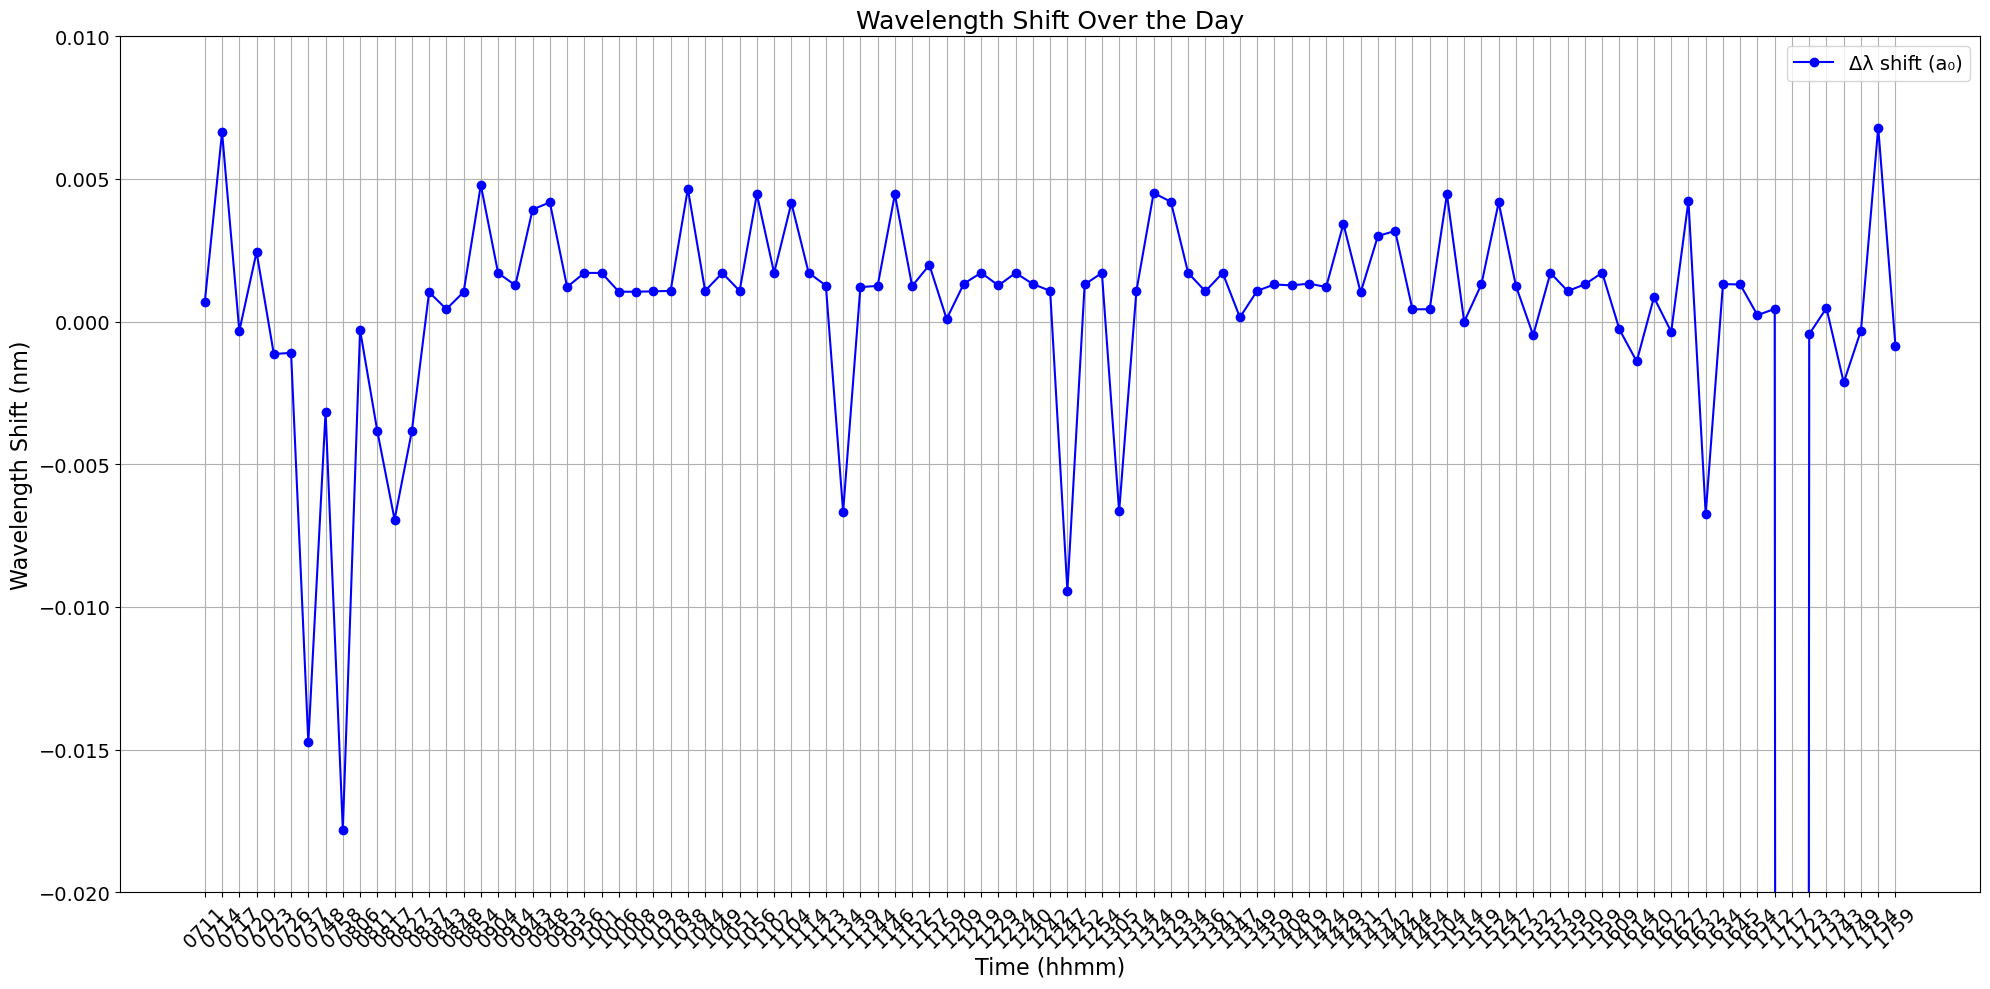

In [19]:
# Find the index where time is 1717
idx_1717 = routine_times.index('1717')
print("Routine index for 1717:", idx_1717)

# === Step 7: Plot wavelength shift and stretch over the day ===
plt.figure(figsize=(20, 10))
plt.plot(routine_times, a_shifts, 'o-', label='Δλ shift (a₀)', color='blue')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time (hhmm)", fontsize=16)
plt.ylabel("Wavelength Shift (nm)", fontsize=16)
plt.title("Wavelength Shift Over the Day", fontsize=18)
plt.ylim(-0.02,0.01)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

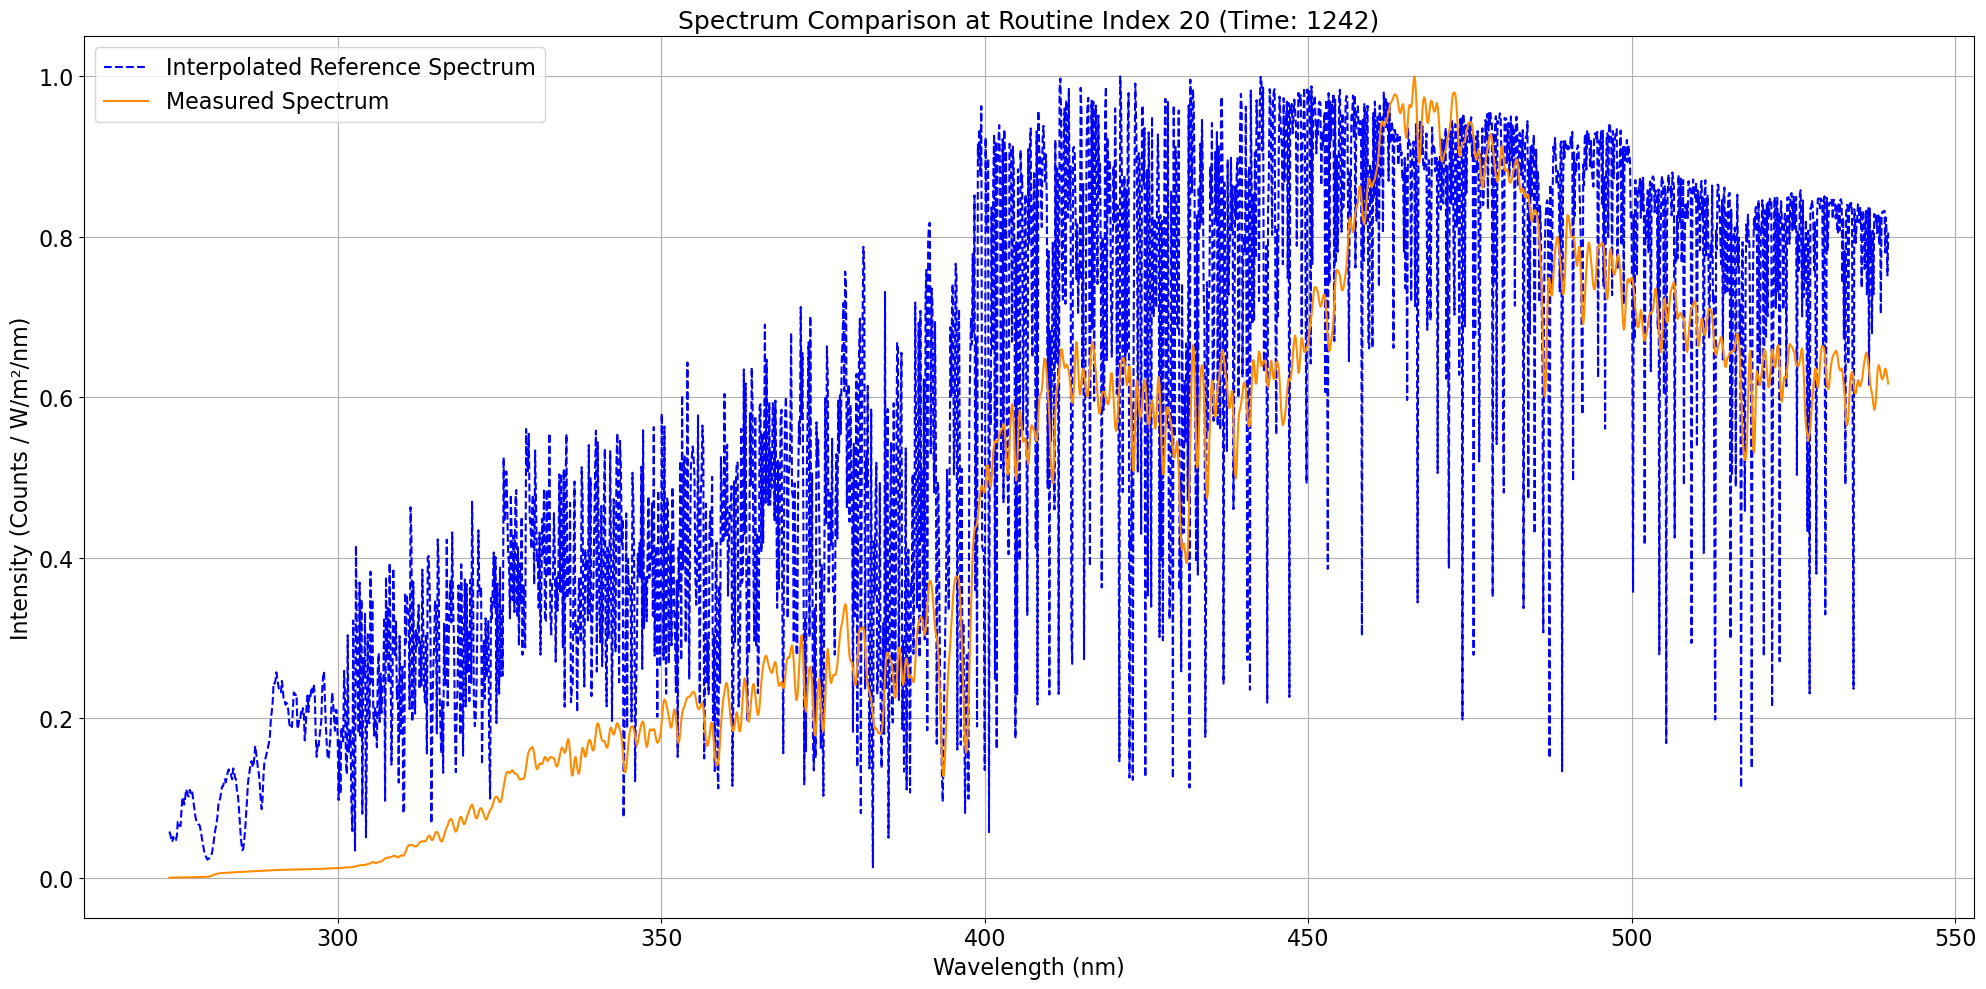

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# -------- Choose a routine index to visualize --------
i = 34  # Change this index to pick different time points

# Get measured spectrum (log scale safe handling)
measured = sq_l0[i]
measured_safe = np.where(measured <= 0, 1e-10, measured)

# Apply the wavelength shift to lo
a0 = a_shifts[i]
lo_shifted = lo + a0  # wavelength shift only

ref_data = pd.read_csv('/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1_270_540nm.csv')
lostd = ref_data.iloc[:, 0].values  # wavelength [nm]
f_synthetic = ref_data.iloc[:, 1].values  # irradiance


# Interpolate reference spectrum to shifted wavelength
ref_interp = np.interp(lo_shifted, lostd, f_synthetic)

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(lo, ref_interp/ max(ref_interp), label='Interpolated Reference Spectrum', color='blue', linestyle='--')
plt.plot(lo, measured/ max(measured), label='Measured Spectrum', color='darkorange')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Intensity (Counts / W/m²/nm)', fontsize=16)
plt.title(f'Spectrum Comparison at Routine Index {i} (Time: {routine_times[i]})', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


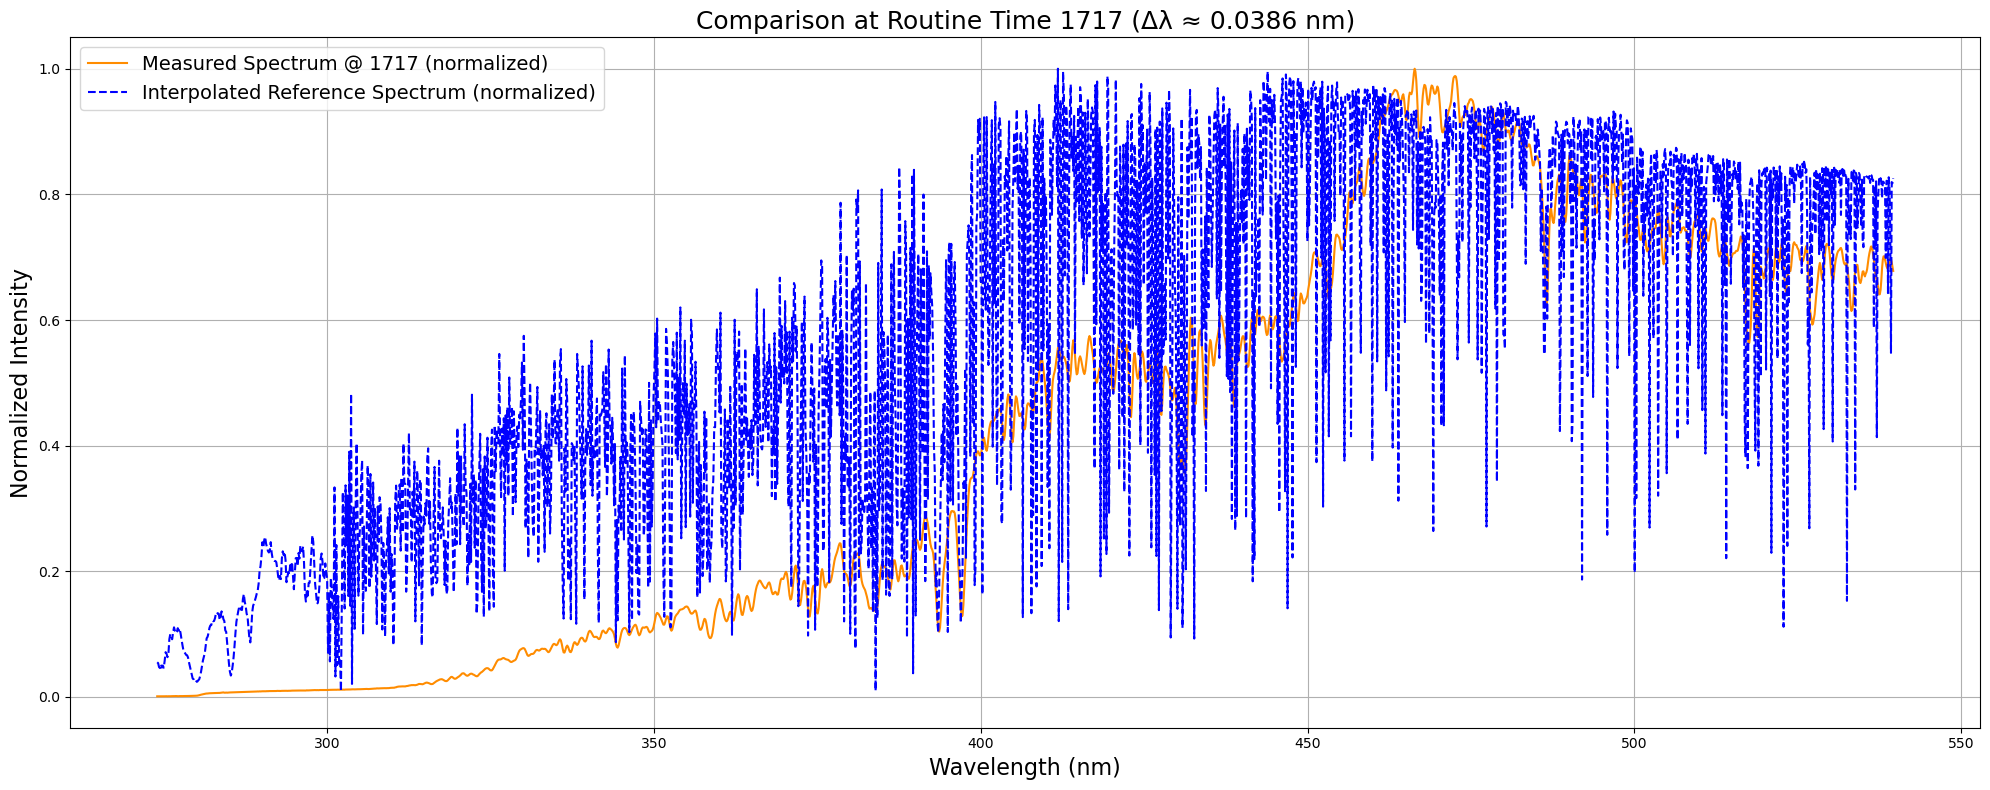

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set routine index (replace with the index found above)
i = idx_1717

# Load reference spectrum again (if not already)
ref_data = pd.read_csv('/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/Panndora_456/Lab_pandora/25_Apr 25_pandora157/Spectre_HR_LATMOS_Meftah_V1_270_540nm.csv')
lostd = ref_data.iloc[:, 0].values
f_synthetic = ref_data.iloc[:, 1].values

# Measured spectrum
measured = sq_l0[i]
measured_safe = np.where(measured <= 0, 1e-10, measured)

# Shifted wavelengths
a0 = a_shifts[i]
lo_shifted = lo + a0

# Interpolated reference
ref_interp = np.interp(lo_shifted, lostd, f_synthetic)

# Plot
plt.figure(figsize=(20, 8))
plt.plot(lo, measured_safe / np.max(measured_safe), label=f'Measured Spectrum @ {routine_times[i]} (normalized)', color='darkorange')
plt.plot(lo, ref_interp / np.max(ref_interp), label='Interpolated Reference Spectrum (normalized)', color='blue', linestyle='--')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Normalized Intensity', fontsize=16)
plt.title(f'Comparison at Routine Time {routine_times[i]} (Δλ ≈ {a0:.4f} nm)', fontsize=18)
plt.legend(fontsize=14)
# plt.xlim(470,490)
plt.grid(True)
plt.tight_layout()
plt.show()
